In [2]:
import gudhi
import numpy as np
import copy
import random

In [2]:
rips_complex = gudhi.RipsComplex(points=[[0], [1], [10], [12]])

simplex_tree = rips_complex.create_simplex_tree(max_dimension=4)
result_str = 'Rips complex is of dimension ' + repr(simplex_tree.dimension()) + ' - ' + \
    repr(simplex_tree.num_simplices()) + ' simplices - ' + \
    repr(simplex_tree.num_vertices()) + ' vertices.'
print(result_str)
fmt = '%s -> %.2f'
fil = list(simplex_tree.get_filtration())
for filtered_value in fil:
    print(fmt % tuple(filtered_value))

Rips complex is of dimension 3 - 15 simplices - 4 vertices.
[0] -> 0.00
[1] -> 0.00
[2] -> 0.00
[3] -> 0.00
[0, 1] -> 1.00
[2, 3] -> 2.00
[1, 2] -> 9.00
[0, 2] -> 10.00
[0, 1, 2] -> 10.00
[1, 3] -> 11.00
[1, 2, 3] -> 11.00
[0, 3] -> 12.00
[0, 1, 3] -> 12.00
[0, 2, 3] -> 12.00
[0, 1, 2, 3] -> 12.00


In [87]:
p = simplex_tree.persistence()

<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

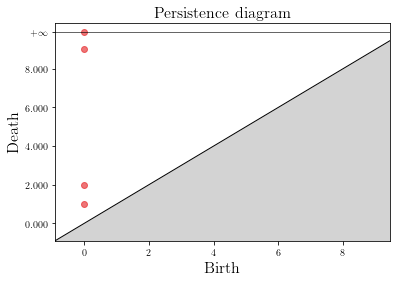

In [88]:
gudhi.plot_persistence_diagram(p)

In [3]:
def invert_permutation(permutation):
    inv = np.empty_like(permutation)
    inv[permutation] = np.arange(len(inv), dtype=inv.dtype)
    return inv

def edge_to_vertices(edges):
    res = list(list(filter(lambda x : x >= 0, edges_)) for edges_ in edges)
    return res

def tree_filtration(scores):
    # Get the whole filtration for a vector of score.
    # Weak oders from any epsilon can be computed from this same filtration.
    pts = [[s_] for s_ in scores]
    rips_complex = gudhi.RipsComplex(points=pts) 
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=len(scores))
    
    return simplex_tree, list(simplex_tree.get_filtration())

def get_buckets(scores, epsilon, filtration=None):
    # Get a printable version of the corresponding weak orders
    
    # If the filtration computation has not been done before
    if filtration == None:
        pts = [[s_] for s_ in scores]
        rips_complex = gudhi.RipsComplex(points=pts) 
        simplex_tree = rips_complex.create_simplex_tree(max_dimension=len(scores))
        filtration = simplex_tree.get_filtration()
    else:
        print(f"Using pre-computed filtration")
    
    # Get only groups with birth date < epsilon and
    # remove groups with death date < epsilon
    output = [[0]]
    for filtered_value in filtration:
        c = 0
        d = 0
        to_remove = list()
        if filtered_value[1] < epsilon:
            for o in output:
                if list(set(o) & set(filtered_value[0])) == list(o):
                    to_remove.append(o)
                    d+=1
                else:
                    c+=1
            for o_ in to_remove:
                output.remove(o_)
            if c == len(output) or d > 0:
                output.append(filtered_value[0])
    
    #output2 = edge_to_vertices(output)
    output2 = output
    
    # Rank the groups found previously
    arg = list(np.argsort(scores)[::-1])
    ranks = list()
    for bucket in output2:
        ranks_ = list()
        for item in bucket:
            rank = arg.index(item)
            ranks_.append(rank)
        ranks.append(np.mean(ranks_))
    argranks = invert_permutation(list(np.argsort(ranks)))
    print(ranks, argranks)
    
    output_dict = dict(zip(argranks, output2))
    return output_dict, arg

In [4]:
#scores = [5,8,6,2,10,1]
scores = [random.randint(0,70) for i in range(3)]+[random.randint(30,100) for i in range(3)]
linf = np.linalg.norm(scores, np.inf)
scores = scores/linf

print(f"scores = {np.round(scores,3)}\nargsort = {np.argsort(scores)[::-1]}")
simplex_tree, fil = tree_filtration(scores)

scores = [0.659 0.366 0.732 0.841 1.    0.805]
argsort = [4 3 5 2 0 1]


<AxesSubplot:title={'center':'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

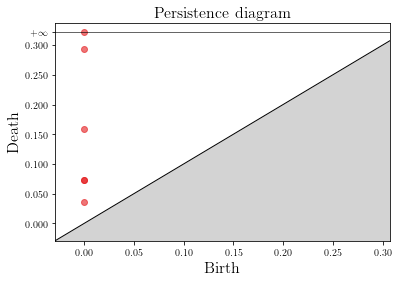

In [5]:
p = simplex_tree.persistence()
gudhi.plot_persistence_diagram(p)

In [6]:
epsilon = 0.25
buckets, args = get_buckets(scores, epsilon, filtration=fil)
print(f"weak order = {buckets}, total order = {args}")

Using pre-computed filtration
[5.0, 2.5, 1.0] [2 1 0]
weak order = {2: [1], 1: [0, 2, 3, 5], 0: [3, 4, 5]}, total order = [4, 3, 5, 2, 0, 1]


In [27]:
epsilon = 0.30
buckets, args = get_buckets(scores, epsilon, filtration=fil)
print(f"weak order = {buckets}, total order = {args}")

Using pre-computed filtration
[0.0, 2.0, 4.0] [0 1 2]
weak order = {0: [4], 1: [0, 3, 5], 2: [1, 2, 5]}, total order = [4, 0, 3, 5, 1, 2]


In [49]:
a = [ 0.7359,  0.3964,  0.3015, -0.5651, -1.0455],
np.linalg.norm(a, ord=2)
1.48/((4)*np.sqrt(5))

0.16546903033498442

In [2]:
import random
wo = {0:[0,1], 1:[1,2]}

def get_sample(wo):
    output_rk = []
    keys = list(wo.keys())
    rd_keys = random.sample(keys, len(keys))
    nb_items_per_rk = dict()
    for rank in rd_keys:        
        possible_items = wo[rank]
        possible_items = list(set(possible_items) - set(output_rk))
        nb_items_per_rk[rank] = len(possible_items)
        rank_previous = int(np.sum([nb_items_per_rk[key] for key in nb_items_per_rk.keys() if key < rank]))
        item = random.sample(possible_items, len(possible_items))
        [output_rk.insert(rank_previous, item_) for item_ in item]
    return output_rk

res_dict = {}
for i in range(5000):
    output_rk = get_sample(wo)
    if str(output_rk) not in res_dict.keys():
        res_dict[str(output_rk)] = 1
    else:
        res_dict[str(output_rk)] += 1

res_dict

{'[1, 0, 2]': 1279, '[0, 1, 2]': 2477, '[0, 2, 1]': 1244}

In [22]:
for key in res_dict.keys():
    res_dict[key] = np.round(res_dict[key]/5000, 3)
res_dict

{'[0, 1, 2]': 0.496, '[1, 0, 2]': 0.245, '[0, 2, 1]': 0.259}

In [106]:
wo = {0:[0,1], 1:[1,2,3], 2:[3,4]}

res_dict = {}
for i in range(100):
    output_rk = get_sample(wo)
    if str(output_rk) not in res_dict.keys():
        res_dict[str(output_rk)] = 1
    else:
        res_dict[str(output_rk)] += 1

res_dict

{'[0, 2, 3, 1, 4]': 5,
 '[1, 0, 2, 3, 4]': 23,
 '[1, 0, 3, 2, 4]': 2,
 '[0, 1, 2, 3, 4]': 15,
 '[1, 0, 2, 4, 3]': 8,
 '[0, 1, 2, 4, 3]': 13,
 '[0, 2, 1, 3, 4]': 8,
 '[0, 1, 3, 2, 4]': 9,
 '[0, 3, 1, 2, 4]': 7,
 '[0, 2, 1, 4, 3]': 5,
 '[0, 3, 2, 1, 4]': 5}

In [3]:
import numpy as np
from geomloss import SamplesLoss
import torch

loss = SamplesLoss("sinkhorn", p=1, blur=0.1)

p = torch.tensor([0.5, 0.5, 0, 0]).view(1,-1)
q = torch.tensor([0, 0.5, 0, 0.5]).view(1,-1)

loss(p,q)

tensor(0.7070)

In [32]:
l = np.matrix([[0,1,1,2],[1,0,2,1],[1,2,0,1],[2,1,1,0]])
l

matrix([[0, 1, 1, 2],
        [1, 0, 2, 1],
        [1, 2, 0, 1],
        [2, 1, 1, 0]])

In [33]:
np.linalg.eig(l)

(array([ 4.00000000e+00, -2.00000000e+00,  1.69006748e-16, -2.00000000e+00]),
 matrix([[-5.00000000e-01, -7.07106781e-01,  5.00000000e-01,
           1.31895186e-01],
         [-5.00000000e-01,  6.54386233e-17, -5.00000000e-01,
          -6.94696811e-01],
         [-5.00000000e-01,  3.93375938e-17, -5.00000000e-01,
           6.94696811e-01],
         [-5.00000000e-01,  7.07106781e-01,  5.00000000e-01,
          -1.31895186e-01]]))

In [3]:
L = np.matrix([[0,1,1,2,2,3],[1,0,2,3,1,2],[1,2,0,1,3,2],[2,3,1,0,2,1],[2,1,3,2,0,1],[3,2,2,1,1,0]])
L

matrix([[0, 1, 1, 2, 2, 3],
        [1, 0, 2, 3, 1, 2],
        [1, 2, 0, 1, 3, 2],
        [2, 3, 1, 0, 2, 1],
        [2, 1, 3, 2, 0, 1],
        [3, 2, 2, 1, 1, 0]])

In [85]:
p = np.matrix([0.35, 0.25, 0.15, 0.1, 0.1, 0.05])
eps = 0.4

p_ = np.matrix([-eps/2,0,0,0,0,eps/2])
ptilde = p + p_

print(f"pL = {np.round(p*L,3)}")
print(f"adv pL = {ptilde*L}")

pL = [[0.95 1.15 1.35 1.85 1.65 2.05]]
adv pL = [[1.55 1.35 1.55 1.65 1.45 1.45]]


In [69]:
(2.05-1.65)/1

0.3999999999999999

In [56]:
deltas = np.linspace(0,3,31)
def get_eps(delta, sl):
    m1 = min(sl[1], sl[2], sl[3], sl[4], sl[5])
    m2 = m = min(sl[3], sl[4], sl[5])
    m3 = sl[5]
    if delta < 1:
        return 0
    elif delta < 2:
        return m1
    elif delta < 3:
        return m1+m2
    else:
        return sl[5]
    
epss = list()
for delta in deltas:
    epss.append(get_eps(delta, v))

In [57]:
epss

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.20000000000000007,
 0.20000000000000007,
 0.20000000000000007,
 0.20000000000000007,
 0.20000000000000007,
 0.20000000000000007,
 0.20000000000000007,
 0.20000000000000007,
 0.20000000000000007,
 0.20000000000000007,
 0.3499999999999999,
 0.3499999999999999,
 0.3499999999999999,
 0.3499999999999999,
 0.3499999999999999,
 0.3499999999999999,
 0.3499999999999999,
 0.3499999999999999,
 0.3499999999999999,
 0.3499999999999999,
 0.36666666666666653]

In [17]:
p = np.matrix([0.22, 0.14, 0.19, 0.12, 0.15, 0.18])
p = np.matrix([0.15, 0.25, 0.3, 0.1, 0.15, 0.05])
#p1 = np.matrix([0.35, 0.25, 0.15, 0.1, 0.1, 0.05])
#p2 = np.matrix([0.5, 0.2, 0.05, 0.05, 0, 0.2])
sig = np.matrix([1, 0, 0, 0, 0, 0])
sig2 = np.matrix([1/5, 1/5, 1/5, 1/5, 1/5, 0])
sig2 = np.matrix([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])

print(f"sum p = {np.sum(p)}")
print(p*L)
print(sig*L)
print(sig2*L)
print(f"diff = {p*L - sig*L}, val = {np.sum(np.square(p*L - sig*L))}")
print(f"diff = {p*L - sig2*L}, val = {np.sum(np.square(p*L - sig2*L))}")

sum p = 1.0
[[1.2 1.3 1.3 1.7 1.7 1.8]]
[[0 1 1 2 2 3]]
[[1.5 1.5 1.5 1.5 1.5 1.5]]
diff = [[ 1.2  0.3  0.3 -0.3 -0.3 -1.2]], val = 3.24
diff = [[-0.3 -0.2 -0.2  0.2  0.2  0.3]], val = 0.33999999999999986


In [229]:
p12 = p[:,0]+p[:,1]+p[:,4]
p13 = p[:,0]+p[:,1]+p[:,2]
p23 = p[:,0]+p[:,2]+p[:,3]
print(f"p12={p12}, p13={p13} and p23={p23}")

p12=[[0.55]], p13=[[0.6]] and p23=[[0.5]]


In [155]:
a_ = 0.1/0.24

In [208]:
eps = 0.0
q_ = np.matrix([-eps/4, 0, -eps/4, 0, eps/4, eps/4])
q = p + q_

print(f"q = {q} and sum q = {np.sum(q)}")
q*L

q = [[0.22 0.14 0.19 0.12 0.15 0.18]] and sum q = 1.0


matrix([[1.41, 1.47, 1.43, 1.53, 1.57, 1.59]])

In [205]:
b = np.array([1.41, 1.47, 1.43, 1.53, 1.57, 1.59])
b = b -1.41
div_ = np.array([1, 1, 1, 2, 2, 3])
div2_ = np.array([0.5, 1.5, 0.5, 1.5, 2.5, 2.5])

np.divide(b, div_)

array([0.  , 0.06, 0.02, 0.06, 0.08, 0.06])

In [178]:
a = np.array([1,2])
b = np.array([3,4])
np.divide(a,b)

array([0.33333333, 0.5       ])

In [215]:
np.linalg.eig(L)

(array([ 9.00000000e+00, -4.00000000e+00, -1.00000000e+00, -3.08528368e-16,
         8.43553044e-17, -4.00000000e+00]),
 matrix([[-0.40824829, -0.57735027,  0.40824829,  0.04764965, -0.35534799,
          -0.12601224],
         [-0.40824829, -0.28867513, -0.40824829, -0.52211905, -0.21640195,
          -0.55095149],
         [-0.40824829, -0.28867513, -0.40824829,  0.4744694 ,  0.57174994,
           0.42493925],
         [-0.40824829,  0.28867513,  0.40824829, -0.52211905, -0.21640195,
           0.55095149],
         [-0.40824829,  0.28867513,  0.40824829,  0.4744694 ,  0.57174994,
          -0.42493925],
         [-0.40824829,  0.57735027, -0.40824829,  0.04764965, -0.35534799,
           0.12601224]]))

# Depth objective -- Dirac vs not Dirac

In [4]:
L = np.matrix([[0,1,1,2,2,3],[1,0,2,3,1,2],[1,2,0,1,3,2],[2,3,1,0,2,1],[2,1,3,2,0,1],[3,2,2,1,1,0]])
p = np.matrix([0.13, 0.27, 0.3, 0.1, 0.15, 0.05])
#p = np.matrix([0.75, 0.0, 0.25, 0.0, 0., 0])
pl = (p*L)
print(f"pL = {pl}")

nu1 = np.matrix([1, 0, 0, 0, 0, 0])
nu2 = np.matrix([0, 1, 0, 0, 0, 0])
nu3 = np.matrix([0, 0, 1, 0, 0, 0])
nu4 = np.matrix([0, 0, 0, 1, 0, 0])
nu5 = np.matrix([0, 0, 0, 0, 1, 0])
nu6 = np.matrix([0, 0, 0, 0, 0, 1])

def loss_depth(q, p):
    pl = p*L
    ql = q*L
    res1 = np.sum(np.square(pl))
    res2 = np.sum(np.square(ql))
    res3 = 2* (pl * ql.T)
    res = res1 + res2 - res3
    print(f"res2={res2}")
    return res

pL = [[1.22 1.28 1.32 1.72 1.68 1.78]]


In [96]:
p = np.matrix([0.13, 0.27, 0.3, 0.1, 0.15, 0.05])
p = np.matrix([0.5, 0.05, 0.1, 0.1, 0.25, 0.0])

q1 = (nu1+nu2)/2
q1bis = (nu1+nu3)/2
q2 = (nu1+nu2+nu3)/3
q3 = (nu1+nu2+nu3+nu5)/4
q4 = (nu1+nu2+nu3+nu4+nu5)/5
q5 = (nu1+nu2+nu3+nu4+nu5+nu6)/6

print(f"loss sigma star = {loss_depth(nu1,p)}")
print(f"loss q1 = {loss_depth(q1,p)} and loss q1bis = {loss_depth(q1bis,p)}")
print(f"loss q2 = {loss_depth(q2,p)}")
print(f"loss q3 = {loss_depth(q3,p)}")
print(f"loss q4 = {loss_depth(q4,p)}")
print(f"loss q5 = {loss_depth(q5,p)}")

res2=19
loss sigma star = [[1.975]]
res2=17.5
res2=17.5
loss q1 = [[1.375]] and loss q1bis = [[2.175]]
res2=15.888888888888886
loss q2 = [[0.59722222]]
res2=14.5
loss q3 = [[0.175]]
res2=13.720000000000002
loss q4 = [[0.295]]
res2=13.5
loss q5 = [[0.975]]


In [107]:
c = 4*5/2 * (13.72-14.5)
print(f"c={c}")

diff_nu = np.matrix([-1,-1,-1,4,-1,0])
print(L*diff_nu.T)
val = p*L * L*diff_nu.T
print(f"val={val}")

float(val) >= c

c=-7.799999999999994
[[ 4]
 [ 8]
 [-2]
 [-8]
 [ 2]
 [-4]]
val=[[-9.]]


False

In [109]:
c = 3*4/2 * (14.5-15.8888888888888)
print(f"c={c}")


c=-8.333333333332803


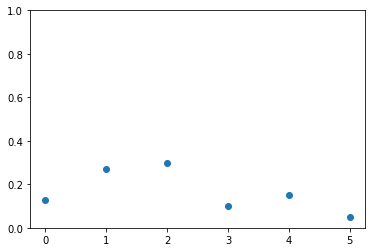

In [5]:
import matplotlib.pyplot as plt
pview = p.tolist()[0]

plt.plot(pview, "o")
plt.ylim(0,1)
plt.show()
#pview

In [5]:
L = np.matrix([[0,1,1,2,2,3],[1,0,2,3,1,2],[1,2,0,1,3,2],[2,3,1,0,2,1],[2,1,3,2,0,1],[3,2,2,1,1,0]])
#p = np.matrix([0.175, 0.17, 0.17, 0.16, 0.17, 0.155])
p = np.matrix([0.13, 0.27, 0.3, 0.1, 0.15, 0.05])

def loss_q(p,L):
    print(f"loss vect = {p*L}\n")
    S_ = {"a":np.matrix([1,0,0,0,0,0]), "b":np.matrix([0,1,0,0,0,0]), "c":np.matrix([0,0,1,0,0,0]), "d":np.matrix([0,0,0,1,0,0]),
         "e":np.matrix([0,0,0,0,1,0]), "f":np.matrix([0,0,0,0,0,1]), "ab":np.matrix([1,1,0,0,0,0]), "ac":np.matrix([1,0,1,0,0,0]),
         "be":np.matrix([0,1,0,0,1,0]), "cd":np.matrix([0,0,1,1,0,0]), "bc":np.matrix([0,1,1,0,0,0])}
    for name, s_ in S_.items():
        m = np.sum(s_>0)
        s = s_/m
        loss_tot = np.round(np.linalg.norm(p*L - s*L, 2)**2,4)
        loss_min = np.round((s-2*p)*(L**2)*s.T,4)
        print(f"loss for {name} = {loss_min} (tot {loss_tot})")

print(p*L)


[[1.22 1.28 1.32 1.72 1.68 1.78]]


In [208]:
np.sum(p)

1.0

In [220]:
loss_q(p,L)

loss vect = [[1.22 1.28 1.32 1.72 1.68 1.78]]

loss for a = [[-10.48]] (tot 3.3384)
loss for b = [[-9.52]] (tot 4.2984)
loss for c = [[-9.2]] (tot 4.6184)
loss for d = [[-6.48]] (tot 7.3384)
loss for e = [[-6.8]] (tot 7.0184)
loss for f = [[-5.52]] (tot 8.2984)
loss for ab = [[-11.5]] (tot 2.3184)
loss for ac = [[-11.34]] (tot 2.4784)
loss for be = [[-9.66]] (tot 4.1584)
loss for cd = [[-9.34]] (tot 4.4784)
loss for bc = [[-13.36]] (tot 0.4584)


In [278]:
p = np.matrix([0.13, 0.27, 0.3, 0.1, 0.15, 0.05])
s1 = np.matrix([1,1,1,1,1,1])/6
print(f"{L}\n{L**2}\n loss2={p*L**2}")
s1*(L**2)*s1.T

[[0 1 1 2 2 3]
 [1 0 2 3 1 2]
 [1 2 0 1 3 2]
 [2 3 1 0 2 1]
 [2 1 3 2 0 1]
 [3 2 2 1 1 0]]
[[19 16 16 11 11  8]
 [16 19 11  8 16 11]
 [16 11 19 16  8 11]
 [11  8 16 19 11 16]
 [11 16  8 11 19 16]
 [ 8 11 11 16 16 19]]
 loss2=[[14.74 14.26 14.1  12.74 12.9  12.26]]


matrix([[13.5]])

In [6]:
def pairwise_prob(p):
    p12 = p[0,0]+p[0,1]+p[0,4]
    p13 = p[0,0]+p[0,1]+p[0,2]
    p23 = p[0,0]+p[0,2]+p[0,3]
    return np.matrix((p12, p13, p23))

In [286]:
#p = np.matrix([0.13, 0.27, 0.3, 0.1, 0.15, 0.05])
p = np.matrix([0.7, 0.2, 0.1, 0.0, 0.0, 0.0])
print(f"{np.sum(p)}")

S_ = {"-> a":np.matrix([1,0,0,0,0,0]), "-> b":np.matrix([0,1,0,0,0,0]), "-> c":np.matrix([0,0,1,0,0,0]), "-> ab":np.matrix([1/2,1/2,0,0,0,0]),
     "-> ac":np.matrix([1/2,0,1/2,0,0,0]), "abc":np.matrix([1/3,1/3,1/3,0,0,0]), "abce":np.matrix([1/4,1/4,1/4,0,1/4,0]),
     "abcde":np.matrix([1/5,1/5,1/5,1/5,1/5,0]), "-> abcdef":np.matrix([1/6,1/6,1/6,1/6,1/6,1/6])}

for name, s_ in S_.items():
    res = np.linalg.norm(pairwise_prob(p)-pairwise_prob(s_),1, axis=1)
    print(f"val for {name} = {res}")

0.9999999999999999
val for -> a = [0.3]
val for -> b = [0.9]
val for -> c = [1.1]
val for -> ab = [0.4]
val for -> ac = [0.6]
val for abc = [0.36666667]
val for abce = [0.7]
val for abcde = [0.9]
val for -> abcdef = [1.2]


In [288]:
a = np.matrix([0.5, 0.3, 0.2])
b = np.matrix([1,0,0])
np.sum(np.abs(a-b))

1.0

In [39]:
p = np.matrix([0.13, 0.27, 0.3, 0.1, 0.15, 0.05])
delta = 2
sigma_star = np.matrix([1,0,0,0,0,0])

sigs = [np.matrix([1,0,0,0,0,0]), np.matrix([0,1,0,0,0,0]), np.matrix([0,0,1,0,0,0]), np.matrix([0,0,0,1,0,0]), np.matrix([0,0,0,0,1,0]), np.matrix([0,0,0,0,0,1])]

def erm_bd_pt(p, delta):
    nu_list = []
    for sig in sigs:
        if sig*L*sigma_star.T >= np.ceil(delta):
            max_val = 0
            for nu in sigs:
                if nu*L*sigma_star.T < np.ceil(delta):
                    L_sig = p*L*sig.T
                    L_nu = p*L*nu.T
                    div = sig*L*nu.T
                    val = ((L_sig-L_nu)/div)[0,0]
                    if val >= max_val:
                        max_val = val
            nu_list.append(max_val)
    return np.min(nu_list)

In [102]:
delta = 1.5
erm_bd_pt(p, delta)

0.25

In [ ]:
def pairwise_bd_pt(p, delta):
    pairwise = pairwise_prob(p)
    #ordered_pair = np.sort(np.abs(pairwise-3/4))
    #ordered_idx = np.argsort(np.abs(pairwise-3/4))
    

In [140]:
p = np.matrix([0.13, 0.27, 0.3, 0.1, 0.15, 0.05])
#p_tilde = np.matrix([0.5, 0.125, 0.125, 0.125, 0.125, 0])
p_tilde = p + np.matrix([0.37,-0.02,-0.05,-0.1,-0.15,-0.05])
print(f"p_tilde={p_tilde}")
l1 = np.linalg.norm(p-p_tilde,1,axis=1)
print(f"L1 norm={l1}")

def get_weak_order(p):
    pair = pairwise_prob(p)
    q = list()
    for i in range(3):
        if pair[0,i] <= 1/4:
            q_ = 0
        elif pair[0,i] < 3/4:
            q_ = 1/2
        else:
            q_ = 1
        q.append(q_)
    return np.asarray(q)

print(f"p->{np.sum(p)} and p_tilde->{np.sum(p_tilde)}")
print(f"pairwise proba p={pairwise_prob(p)} and p_tilde={pairwise_prob(p_tilde)}")

p_tilde=[[0.5  0.25 0.25 0.   0.   0.  ]]
L1 norm=[0.74]
p->1.0 and p_tilde->1.0
pairwise proba p=[[0.55 0.7  0.53]] and p_tilde=[[0.75 1.   0.75]]


In [131]:
pair_p = pairwise_prob(p)
pair_p_tilde = pairwise_prob(p_tilde)
wp = get_weak_order(p)
wp_tilde = get_weak_order(p_tilde)
print(f"wp={wp} and wp_tilde={wp_tilde}")

wp=[0.5 0.5 0.5] and wp_tilde=[0.5 1.  0.5]


In [132]:
np.linalg.norm(wp-wp_tilde, 1)

0.5

In [128]:
np.abs(pair_p - 3/4)

matrix([[0.2 , 0.05, 0.22]])

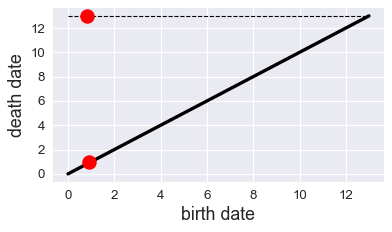

In [34]:
plt.style.use("seaborn")

lx = np.array([0,13])
ly = np.array([0,13])
lx2 = np.array([0,13])
ly2 = np.array([13,13])

x = np.array([0.8, 0.9])
y = np.array([13, 1])

plt.figure(figsize=(5, 3), dpi=80)
plt.plot(lx, ly, "-", color="black", linewidth=3)
plt.plot(lx2, ly2, "--", color="black", linewidth=1)
plt.plot(x, y, "o", color="red", ms=13)
plt.xlabel("birth date", fontsize=16)
plt.ylabel("death date", fontsize=16)
plt.locator_params(axis="x", nbins=8)
plt.locator_params(axis="y", nbins=8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("/Users/m.goibert/Downloads/pd_illustration_main1.png", dpi=150)

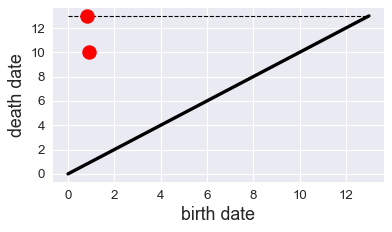

In [35]:
plt.style.use("seaborn")

lx = np.array([0,13])
ly = np.array([0,13])
lx2 = np.array([0,13])
ly2 = np.array([13,13])

x = np.array([0.8, 0.9])
y = np.array([13, 10])

plt.figure(figsize=(5, 3), dpi=80)
plt.plot(lx, ly, "-", color="black", linewidth=3)
plt.plot(lx2, ly2, "--", color="black", linewidth=1)
plt.plot(x, y, "o", color="red", ms=13)
plt.xlabel("birth date", fontsize=16)
plt.ylabel("death date", fontsize=16)
plt.locator_params(axis="x", nbins=8)
plt.locator_params(axis="y", nbins=8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("/Users/m.goibert/Downloads/pd_illustration_main2.png", dpi=150)

In [13]:
A = np.matrix([[0,0.1,-0.2],[-0.1,0,-0.28],[0.2,0.28,0]])
S = np.matrix([[0,0,1],[1,0,1],[0,0,0]])

S*A.T

matrix([[-0.2 , -0.28,  0.  ],
        [-0.2 , -0.38,  0.2 ],
        [ 0.  ,  0.  ,  0.  ]])

In [16]:
S*A
#np.trace(S*A)

matrix([[ 0.2 ,  0.28,  0.  ],
        [ 0.2 ,  0.38, -0.2 ],
        [ 0.  ,  0.  ,  0.  ]])

In [18]:
S.T * A

matrix([[-0.1 ,  0.  , -0.28],
        [ 0.  ,  0.  ,  0.  ],
        [-0.1 ,  0.1 , -0.48]])

In [2]:
L = np.matrix([[0,1,1,2,2,3],[1,0,2,3,1,2],[1,2,0,1,3,2],[2,3,1,0,2,1],[2,1,3,2,0,1],[3,2,2,1,1,0]])

p = np.matrix([0.35, 0.24, 0.12, 0.11, 0.18, 0.09])
print(f"sum of p = {np.sum(p)}")

np.linalg.norm(p*L, 1, axis=1)
p*L

p12 = p[0,0]+p[0,1]+p[0,4]
p23 = p[0,0]+p[0,2]+p[0,3]
p13 = p[0,0]+p[0,1]+p[0,2]
print(f"p12={p12}, p23={p23}, p13={p13}")

sum of p = 1.09
p12=0.77, p23=0.58, p13=0.71


2.06

In [53]:
#q = np.matrix([1/2, 1/2, 0, 0, 0, 0])
#q = np.matrix([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
q = np.matrix([1/2, 0, 0, 0, 1/2, 0])

print(f"Diff = {p*L - q*L}")
norm = np.linalg.norm(p*L - q*L, 1, axis=1)
print(f"norm = {norm}")

Diff = [[ 0.21  0.28 -0.34 -0.01  0.61  0.06]]
norm = [1.51]


In [57]:
N = np.matrix([[3,1,2,0,2,1],[1,3,2,2,0,1],[2,2,3,1,1,0],[0,2,1,3,1,2],[2,0,1,1,3,2],[1,1,0,2,2,3]])

p12=0.6
p23=0.7
p13=0.85
p21=1-p12
p32=1-p23
p31=1-p13
pair_p = np.array([p12,p23,p13,p21,p32,p31])

q12=0.5
q23=0.5
q13=0/5
q21=1-q12
q32=1-q23
q31=1-q13
pair_q = np.array([q12,q23,q13,q21,q32,q31])

2*pair_p - pair_q

array([ 0.7,  0.9,  1.7,  0.3,  0.1, -0.7])

In [60]:
N

matrix([[3, 1, 2, 0, 2, 1],
        [1, 3, 2, 2, 0, 1],
        [2, 2, 3, 1, 1, 0],
        [0, 2, 1, 3, 1, 2],
        [2, 0, 1, 1, 3, 2],
        [1, 1, 0, 2, 2, 3]])

In [6]:
from itertools import permutations
n=6
m=np.math.factorial(n)

bucket = np.arange(n, dtype=int)
perms_ = list(set(permutations(bucket)))
perms = [np.array(perms__) for perms__ in perms_]

In [111]:
sample = np.asarray(perms)

In [122]:
i_ = 1
j_ = 0
k_ = 4
l_ = j_

count = 0
for perm in sample:
    idxi = list(perm).index(i_)
    idxj = list(perm).index(j_)
    idxk = list(perm).index(k_)
    idxl = list(perm).index(l_)
    
    if (idxi > idxj) and (idxk > idxl):
        print(f"perm {perm}")
        count += 1

print(f"Total count = {count}")

perm [2 0 4 3 5 1]
perm [2 0 5 1 3 4]
perm [0 5 4 1 2 3]
perm [3 0 5 2 1 4]
perm [0 2 3 5 1 4]
perm [0 4 1 2 3 5]
perm [3 0 1 2 4 5]
perm [0 4 5 2 3 1]
perm [3 5 0 4 2 1]
perm [0 3 1 2 4 5]
perm [0 3 5 2 4 1]
perm [0 5 2 4 3 1]
perm [2 5 3 0 4 1]
perm [0 2 5 3 4 1]
perm [3 2 0 4 1 5]
perm [5 0 4 2 1 3]
perm [0 4 3 2 1 5]
perm [3 0 2 4 1 5]
perm [0 2 4 5 3 1]
perm [0 5 4 3 1 2]
perm [2 5 0 4 1 3]
perm [0 4 2 1 3 5]
perm [0 5 3 1 4 2]
perm [3 0 5 4 2 1]
perm [0 1 2 3 5 4]
perm [0 5 1 3 4 2]
perm [0 5 2 1 4 3]
perm [0 5 1 4 2 3]
perm [5 0 4 3 2 1]
perm [3 0 2 1 4 5]
perm [0 3 2 4 1 5]
perm [0 4 2 3 5 1]
perm [3 0 4 1 2 5]
perm [2 0 1 5 4 3]
perm [2 3 0 1 4 5]
perm [0 3 4 1 5 2]
perm [2 5 0 3 4 1]
perm [3 0 2 5 4 1]
perm [0 3 5 1 4 2]
perm [2 0 5 4 1 3]
perm [5 2 0 3 1 4]
perm [3 0 1 5 2 4]
perm [0 3 1 5 2 4]
perm [0 1 4 3 2 5]
perm [0 3 2 5 4 1]
perm [3 0 4 2 5 1]
perm [0 1 3 5 2 4]
perm [0 2 1 3 5 4]
perm [3 5 0 1 4 2]
perm [0 1 5 3 4 2]
perm [2 3 0 4 1 5]
perm [5 0 1 2 4 3]
perm [5 3 0 

In [140]:
x1 = np.array([3,0])
x2 = np.array([-1,3])

25.0

In [95]:
from scipy import optimize

c = np.array([0,9,10,9,0,25,10,25,0])
A_eq = np.matrix([[1,1,1,0,0,0,0,0,0],[0,0,0,1,1,1,0,0,0],[0,0,0,0,0,0,1,1,1],[1,0,0,1,0,0,1,0,0],[0,1,0,0,1,0,0,1,0],[0,0,1,0,0,1,0,0,1]])
b_eq = np.matrix([0.1,0.15,0.75,1/3,1/3,1/3])
bounds = (0,1)

optim_val = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
optim_val


/var/folders/lv/q8rb__s56z713dgsz22yrb4w0000gp/T/ipykernel_53740/1416951819.py:8: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  optim_val = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)


     con: array([-6.92094854e-11, -6.80159540e-11, -5.36968248e-11, -6.36410924e-11,
       -6.36405928e-11, -6.36406483e-11])
     fun: 6.316666666686869
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([1.64048728e-11, 1.00000000e-01, 9.57820807e-12, 4.94514362e-12,
       1.50000000e-01, 2.68765371e-12, 3.33333333e-01, 8.33333333e-02,
       3.33333333e-01])

In [160]:
cost_mat = c.reshape(3,3)

x_val = optim_val.x.reshape(3,3)
x_val = np.round(x_val, 3)
print(f"{x_val}\n{cost_mat}")

[[0.    0.1   0.   ]
 [0.    0.15  0.   ]
 [0.333 0.083 0.333]]
[[ 0  9 10]
 [ 9  0 25]
 [10 25  0]]


In [162]:
print(x_val@cost_mat)
x_tent = np.matrix([[0.1,0,0],[0,0.15,0],[1/3-0.1,1/3-0.15,1/3]])
print(x_tent@cost_mat)

[[ 0.9    0.     2.5  ]
 [ 1.35   0.     3.75 ]
 [ 4.077 11.322  5.405]]
[[ 0.          0.9         1.        ]
 [ 1.35        0.          3.75      ]
 [ 4.98333333 10.43333333  6.91666667]]


In [21]:
L = np.matrix([[0,1,1,2,2,3],[1,0,2,3,1,2],[1,2,0,1,3,2],[2,3,1,0,2,1],[2,1,3,2,0,1],[3,2,2,1,1,0]])

p = np.matrix([0.5, 0.2, 0.17, 0.05, 0.06, 0.02])
q1 = np.matrix([0.5, 0.5, 0.0, 0.0, 0.0, 0.0])
q2 = np.matrix([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
print(f"sum of p = {np.sum(p)}")

np.linalg.norm(p*L, 1, axis=1)
print(p*L, q1*L, q2*L)

p12 = p[0,0]+p[0,1]+p[0,4]
p23 = p[0,0]+p[0,2]+p[0,3]
p13 = p[0,0]+p[0,1]+p[0,2]
print(f"p12={p12}, p23={p23}, p13={p13}\n p1_(2=3)={1/2*(p12+p13)}")

sum of p = 1.0
[[0.65 1.09 1.17 1.91 1.83 2.35]] [[0.5 0.5 1.5 2.5 1.5 2.5]] [[1.5 1.5 1.5 1.5 1.5 1.5]]
p12=0.76, p23=0.7200000000000001, p13=0.87
 p1_(2=3)=0.815


In [22]:
np.linalg.norm(p*L-q1*L, 1, axis=1)

array([2.14])

In [23]:
np.linalg.norm(p*L-q2*L, 1, axis=1)

array([3.18])

In [2]:
cuda_source = """

#include <torch/extension.h>
#include <ATen/core/TensorAccessor.h>
#include <ATen/cuda/CUDAContext.h>

using at::RestrictPtrTraits;
using at::PackedTensorAccessor;

#if defined(__HIP_PLATFORM_HCC__)
constexpr int WARP_SIZE = 64;
#else
constexpr int WARP_SIZE = 32;
#endif

// The maximum number of threads in a block
#if defined(__HIP_PLATFORM_HCC__)
constexpr int MAX_BLOCK_SIZE = 256;
#else
constexpr int MAX_BLOCK_SIZE = 512;
#endif

// Returns the index of the most significant 1 bit in `val`.
__device__ __forceinline__ int getMSB(int val) {
  return 31 - __clz(val);
}

// Number of threads in a block given an input size up to MAX_BLOCK_SIZE
static int getNumThreads(int nElem) {
#if defined(__HIP_PLATFORM_HCC__)
  int threadSizes[5] = { 16, 32, 64, 128, MAX_BLOCK_SIZE };
#else
  int threadSizes[5] = { 32, 64, 128, 256, MAX_BLOCK_SIZE };
#endif
  for (int i = 0; i != 5; ++i) {
    if (nElem <= threadSizes[i]) {
      return threadSizes[i];
    }
  }
  return MAX_BLOCK_SIZE;
}

template <typename T>
__device__ __forceinline__ T WARP_SHFL_XOR(T value, int laneMask, int width = warpSize, unsigned int mask = 0xffffffff)
{
#if CUDA_VERSION >= 9000
    return __shfl_xor_sync(mask, value, laneMask, width);
#else
    return __shfl_xor(value, laneMask, width);
#endif
}

// While this might be the most efficient sinkhorn step / logsumexp-matmul implementation I have seen,
// this is awfully inefficient compared to matrix multiplication and e.g. NVidia cutlass may provide
// many great ideas for improvement
template <typename scalar_t, typename index_t>
__global__ void sinkstep_kernel(
  // compute log v_bj = log nu_bj - logsumexp_i 1/lambda dist_ij - log u_bi
  // for this compute maxdiff_bj = max_i(1/lambda dist_ij - log u_bi)
  // i = reduction dim, using threadIdx.x
  PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_v,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> dist,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_nu,
  const PackedTensorAccessor<scalar_t, 2, RestrictPtrTraits, index_t> log_u,
  const scalar_t lambda) {

  using accscalar_t = scalar_t;

  __shared__ accscalar_t shared_mem[2 * WARP_SIZE];

  index_t b = blockIdx.y;
  index_t j = blockIdx.x;
  int tid = threadIdx.x;

  if (b >= log_u.size(0) || j >= log_v.size(1)) {
    return;
  }
  // reduce within thread
  accscalar_t max = -std::numeric_limits<accscalar_t>::infinity();
  accscalar_t sumexp = 0;
  
  if (log_nu[b][j] == -std::numeric_limits<accscalar_t>::infinity()) {
    if (tid == 0) {
      log_v[b][j] = -std::numeric_limits<accscalar_t>::infinity();
    }
    return;
  }

  for (index_t i = threadIdx.x; i < log_u.size(1); i += blockDim.x) {
    accscalar_t oldmax = max;
    accscalar_t value = -dist[i][j]/lambda + log_u[b][i];
    max = max > value ? max : value;
    if (oldmax == -std::numeric_limits<accscalar_t>::infinity()) {
      // sumexp used to be 0, so the new max is value and we can set 1 here,
      // because we will come back here again
      sumexp = 1;
    } else {
      sumexp *= exp(oldmax - max);
      sumexp += exp(value - max); // if oldmax was not -infinity, max is not either...
    }
  }
  
  // now we have one value per thread. we'll make it into one value per warp
  // first warpSum to get one value per thread to
  // one value per warp
  for (int i = 0; i < getMSB(WARP_SIZE); ++i) {
    accscalar_t o_max    = WARP_SHFL_XOR(max, 1 << i, WARP_SIZE);
    accscalar_t o_sumexp = WARP_SHFL_XOR(sumexp, 1 << i, WARP_SIZE);
    if (o_max > max) { // we're less concerned about divergence here
      sumexp *= exp(max - o_max);
      sumexp += o_sumexp;
      max = o_max;
    } else if (max != -std::numeric_limits<accscalar_t>::infinity()) {
      sumexp += o_sumexp * exp(o_max - max);
    }
  }
  
  __syncthreads();
  // this writes each warps accumulation into shared memory
  // there are at most WARP_SIZE items left because
  // there are at most WARP_SIZE**2 threads at the beginning
  if (tid % WARP_SIZE == 0) {
    shared_mem[tid / WARP_SIZE * 2] = max;
    shared_mem[tid / WARP_SIZE * 2 + 1] = sumexp;
  }
  __syncthreads();
  if (tid < WARP_SIZE) {
    max = (tid < blockDim.x / WARP_SIZE ? shared_mem[2 * tid] : -std::numeric_limits<accscalar_t>::infinity());
    sumexp = (tid < blockDim.x / WARP_SIZE ? shared_mem[2 * tid + 1] : 0);
  }
  for (int i = 0; i < getMSB(WARP_SIZE); ++i) {
    accscalar_t o_max    = WARP_SHFL_XOR(max, 1 << i, WARP_SIZE);
    accscalar_t o_sumexp = WARP_SHFL_XOR(sumexp, 1 << i, WARP_SIZE);
    if (o_max > max) { // we're less concerned about divergence here
      sumexp *= exp(max - o_max);
      sumexp += o_sumexp;
      max = o_max;
    } else if (max != -std::numeric_limits<accscalar_t>::infinity()) {
      sumexp += o_sumexp * exp(o_max - max);
    }
  }

  if (tid == 0) {
    log_v[b][j] = (max > -std::numeric_limits<accscalar_t>::infinity() ?
                   log_nu[b][j] - log(sumexp) - max : 
                   -std::numeric_limits<accscalar_t>::infinity());
  }
}

template <typename scalar_t>
torch::Tensor sinkstep_cuda_template(const torch::Tensor& dist, const torch::Tensor& log_nu, const torch::Tensor& log_u,
                                     const double lambda) {
  TORCH_CHECK(dist.is_cuda(), "need cuda tensors");
  TORCH_CHECK(dist.device() == log_nu.device() && dist.device() == log_u.device(), "need tensors on same GPU");
  TORCH_CHECK(dist.dim()==2 && log_nu.dim()==2 && log_u.dim()==2, "invalid sizes");
  TORCH_CHECK(dist.size(0) == log_u.size(1) &&
           dist.size(1) == log_nu.size(1) &&
           log_u.size(0) == log_nu.size(0), "invalid sizes");
  auto log_v = torch::empty_like(log_nu);
  using index_t = int32_t;
  
  auto log_v_a = log_v.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto dist_a = dist.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto log_nu_a = log_nu.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  auto log_u_a = log_u.packed_accessor<scalar_t, 2, RestrictPtrTraits, index_t>();
  
  auto stream = at::cuda::getCurrentCUDAStream();

  int tf = getNumThreads(log_u.size(1));
  dim3 blocks(log_v.size(1), log_u.size(0));
  dim3 threads(tf);
  
  sinkstep_kernel<<<blocks, threads, 2*WARP_SIZE*sizeof(scalar_t), stream>>>(
    log_v_a, dist_a, log_nu_a, log_u_a, static_cast<scalar_t>(lambda)
    );

  return log_v;
}

torch::Tensor sinkstep_cuda(const torch::Tensor& dist, const torch::Tensor& log_nu, const torch::Tensor& log_u,
                            const double lambda) {
    return AT_DISPATCH_FLOATING_TYPES(log_u.scalar_type(), "sinkstep", [&] {
       return sinkstep_cuda_template<scalar_t>(dist, log_nu, log_u, lambda);
    });
}

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("sinkstep", &sinkstep_cuda, "sinkhorn step");
}

"""

In [4]:
import torch
import ninja
from torch.utils import cpp_extension

#wasserstein_ext = cpp_extension.load_inline("wasserstein", cpp_sources="", cuda_sources=cuda_source,
#                                                    extra_cuda_cflags=["--expt-relaxed-constexpr"]   )

def sinkstep(dist, log_nu, log_u, lam: float):
    # dispatch to optimized GPU implementation for GPU tensors, slow fallback for CPU
    #if dist.is_cuda:
    #    return wasserstein_ext.sinkstep(dist, log_nu, log_u, lam)
    assert dist.dim() == 2 and log_nu.dim() == 2 and log_u.dim() == 2
    assert dist.size(0) == log_u.size(1) and dist.size(1) == log_nu.size(1) and log_u.size(0) == log_nu.size(0)
    log_v = log_nu.clone()
    for b in range(log_u.size(0)):
        log_v[b] -= torch.logsumexp(-dist/lam+log_u[b, :, None], 0)
    return log_v

class SinkhornOT(torch.autograd.Function):
    @staticmethod
    def forward(ctx, mu, nu, dist, lam=1e-3, N=100):
        assert mu.dim() == 2 and nu.dim() == 2 and dist.dim() == 2
        bs = mu.size(0)
        d1, d2 = dist.size()
        assert nu.size(0) == bs and mu.size(1) == d1 and nu.size(1) == d2
        log_mu = mu.log()
        log_nu = nu.log()
        log_u = torch.full_like(mu, -math.log(d1))
        log_v = torch.full_like(nu, -math.log(d2))
        for i in range(N):
            log_v = sinkstep(dist, log_nu, log_u, lam)
            log_u = sinkstep(dist.t(), log_mu, log_v, lam)

        # this is slight abuse of the function. it computes (diag(exp(log_u))*Mt*exp(-Mt/lam)*diag(exp(log_v))).sum()
        # in an efficient (i.e. no bxnxm tensors) way in log space
        distances = (-sinkstep(-dist.log()+dist/lam, -log_v, log_u, 1.0)).logsumexp(1).exp()
        ctx.log_v = log_v
        ctx.log_u = log_u
        ctx.dist = dist
        ctx.lam = lam
        return distances

    @staticmethod
    def backward(ctx, grad_out):
        return grad_out[:, None] * ctx.log_u * ctx.lam, grad_out[:, None] * ctx.log_v * ctx.lam, None, None, None
    

def get_coupling(mu, nu, dist, lam=1e-3, N=1000):
    assert mu.dim() == 2 and nu.dim() == 2 and dist.dim() == 2
    bs = mu.size(0)
    d1, d2 = dist.size()
    assert nu.size(0) == bs and mu.size(1) == d1 and nu.size(1) == d2
    log_mu = mu.log()
    log_nu = nu.log()
    log_u = torch.full_like(mu, -math.log(d1))
    log_v = torch.full_like(nu, -math.log(d2))
    for i in range(N):
        log_v = sinkstep(dist, log_nu, log_u, lam)
        log_u = sinkstep(dist.t(), log_mu, log_v, lam)
    return (log_v[:, None, :]-dist/lam+log_u[:, :, None]).exp()

In [41]:
x = torch.tensor([[0.7,0.25,0.05],[0.5, 0.3, 0.2],[0.6, 0.15, 0.25]], requires_grad=True)
y = torch.tensor([[1,0,0], [1,0,0],[1,0,0]])
print(x)
print(y)

dist = torch.tensor([[0,1,1],[1,0,1],[1,1,0]])

tensor([[0.7000, 0.2500, 0.0500],
        [0.5000, 0.3000, 0.2000],
        [0.6000, 0.1500, 0.2500]], requires_grad=True)
tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]])


In [42]:
loss = SinkhornOT()

my_loss = loss.apply(x,y,dist)
#my_loss.backward()

In [43]:
my_loss

tensor([0.3000, 0.5000, 0.4000], grad_fn=<SinkhornOTBackward>)

In [46]:
coupling = get_coupling(x, y, dist)

In [47]:
coupling

tensor([[[0.7000, 0.0000, 0.0000],
         [0.2500, 0.0000, 0.0000],
         [0.0500, 0.0000, 0.0000]],

        [[0.5000, 0.0000, 0.0000],
         [0.3000, 0.0000, 0.0000],
         [0.2000, 0.0000, 0.0000]],

        [[0.6000, 0.0000, 0.0000],
         [0.1500, 0.0000, 0.0000],
         [0.2500, 0.0000, 0.0000]]], grad_fn=<ExpBackward0>)

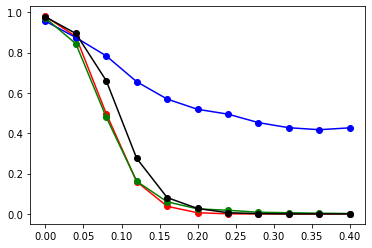

In [49]:
# MNIST MLP
adv_wasserstein = {0.0: 0.97998046875, 0.04: 0.87890625, 0.08: 0.49658203125, 0.12: 0.15966796875, 0.16: 0.03759765625, 0.2: 0.005859375, 0.24: 0.00048828125, 0.28: 0.0, 0.32: 0.0, 0.36: 0.0, 0.4: 0.0}
adv_ce = {0.0: 0.9765625, 0.04: 0.89453125, 0.08: 0.66015625, 0.12: 0.27490234375, 0.16: 0.0810546875, 0.2: 0.02685546875, 0.24: 0.005859375, 0.28: 0.00146484375, 0.32: 0.0, 0.36: 0.0, 0.4: 0.0}
adv_auto_wasserstein = {0.0: 0.95556640625, 0.04: 0.87451171875, 0.08: 0.783203125, 0.12: 0.6552734375, 0.16: 0.5693359375, 0.2: 0.5185546875, 0.24: 0.49462890625, 0.28: 0.45263671875, 0.32: 0.42724609375, 0.36: 0.41748046875, 0.4: 0.4267578125}
adv_auto_wasserstein2 = {0.0: 0.97119140625, 0.04: 0.84375, 0.08: 0.47900390625, 0.12: 0.16162109375, 0.16: 0.06005859375, 0.2: 0.02490234375, 0.24: 0.01806640625, 0.28: 0.00830078125, 0.32: 0.005859375, 0.36: 0.00341796875, 0.4: 0.001953125}


plt.plot(adv_wasserstein.keys(), adv_wasserstein.values(), "o-", color="red")
plt.plot(adv_auto_wasserstein.keys(), adv_auto_wasserstein.values(), "o-", color="blue")
plt.plot(adv_auto_wasserstein2.keys(), adv_auto_wasserstein2.values(), "o-", color="green")
plt.plot(adv_ce.keys(), adv_ce.values(), "o-", color="black")
plt.show()


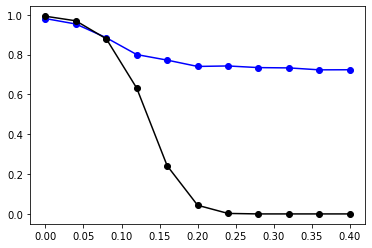

In [50]:
# MNIST LeNet
adv_ce = {0.0: 0.9921875, 0.04: 0.96923828125, 0.08: 0.87890625, 0.12: 0.63134765625, 0.16: 0.24169921875, 0.2: 0.04345703125, 0.24: 0.00244140625, 0.28: 0.0, 0.32: 0.0, 0.36: 0.0, 0.4: 0.0}
adv_auto_wasserstein = {0.0: 0.98046875, 0.04: 0.953125, 0.08: 0.88427734375, 0.12: 0.7998046875, 0.16: 0.77197265625, 0.2: 0.740234375, 0.24: 0.74267578125, 0.28: 0.734375, 0.32: 0.73291015625, 0.36: 0.72314453125, 0.4: 0.7236328125}


plt.plot(adv_auto_wasserstein.keys(), adv_auto_wasserstein.values(), "o-", color="blue")
plt.plot(adv_ce.keys(), adv_ce.values(), "o-", color="black")
plt.show()

In [5]:
import numpy as np
from scipy import optimize

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
c = np.array([0,1,1,1,0,1,1,1,0])
A_eq = np.matrix([[1,1,1,0,0,0,0,0,0],[0,0,0,1,1,1,0,0,0],[0,0,0,0,0,0,1,1,1],[1,0,0,1,0,0,1,0,0],[0,1,0,0,1,0,0,1,0],[0,0,1,0,0,1,0,0,1]])
b_eq = np.matrix([0.1,0.15,0.75,1/3,1/3,1/3])
bounds = (0,1)

optim_val = optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
optim_val

           con: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -5.55111512e-17])
 crossover_nit: 0
         eqlin:  marginals: array([-1., -1., -0.,  1.,  1., -0.])
  residual: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -5.55111512e-17])
           fun: 0.41666666666666663
       ineqlin:  marginals: array([], dtype=float64)
  residual: array([], dtype=float64)
         lower:  marginals: array([0., 1., 2., 1., 0., 2., 0., 0., 0.])
  residual: array([0.1       , 0.        , 0.        , 0.        , 0.15      ,
       0.        , 0.23333333, 0.18333333, 0.33333333])
       message: 'Optimization terminated successfully. (HiGHS Status 7: Optimal)'
           nit: 5
         slack: array([], dtype=float64)
        status: 0
       success: True
         upper:  marginals: array([0., 0., 0., 0., 0., 0., 0., 0., 0.])
  residual: array([0.9       , 1.        , 1.        , 1.        , 0.

In [97]:
list_bucket

[[array([0, 1, 2, 3]), array([0, 1, 3, 2])],
 [array([0, 1, 2, 3]), array([0, 2, 1, 3])],
 [array([0, 1, 2, 3]), array([1, 0, 2, 3])],
 [array([0, 1, 3, 2]), array([0, 1, 2, 3])],
 [array([0, 1, 3, 2]), array([0, 3, 1, 2])],
 [array([0, 1, 3, 2]), array([1, 0, 3, 2])],
 [array([0, 2, 1, 3]), array([0, 1, 2, 3])],
 [array([0, 2, 1, 3]), array([0, 2, 3, 1])],
 [array([0, 2, 1, 3]), array([2, 0, 1, 3])],
 [array([0, 2, 3, 1]), array([0, 2, 1, 3])],
 [array([0, 2, 3, 1]), array([0, 3, 2, 1])],
 [array([0, 2, 3, 1]), array([2, 0, 3, 1])],
 [array([0, 3, 1, 2]), array([0, 1, 3, 2])],
 [array([0, 3, 1, 2]), array([0, 3, 2, 1])],
 [array([0, 3, 1, 2]), array([3, 0, 1, 2])],
 [array([0, 3, 2, 1]), array([0, 2, 3, 1])],
 [array([0, 3, 2, 1]), array([0, 3, 1, 2])],
 [array([0, 3, 2, 1]), array([3, 0, 2, 1])],
 [array([1, 0, 2, 3]), array([0, 1, 2, 3])],
 [array([1, 0, 2, 3]), array([1, 0, 3, 2])],
 [array([1, 0, 2, 3]), array([1, 2, 0, 3])],
 [array([1, 0, 3, 2]), array([0, 1, 3, 2])],
 [array([1

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [5]:
import itertools
import torch
import numpy as np


def kendall_tau(y, sigma):
    y = torch.from_numpy(y)
    sigma = torch.from_numpy(sigma)
    n = sigma.size()[-1]
    sigma_inv = torch.argsort(sigma, dim=-1)
    y_inv = torch.argsort(y, dim=-1)
    sigma_pairs = (sigma_inv.unsqueeze(dim=-1) > sigma_inv.unsqueeze(dim=-2)).float()
    y_pairs = (y_inv.unsqueeze(dim=-1) > y_inv.unsqueeze(dim=-2)).float()
    return torch.sum(torch.abs(sigma_pairs-y_pairs), dim=[-2,-1])/2 #/(n*(n-1))

def kendall_matrix(all_ranks):
    K = np.zeros((len(all_ranks),len(all_ranks)))
    for i, rank1 in enumerate(all_ranks):
        for j, rank2 in enumerate(all_ranks):
            K[i,j] = kendall_tau(rank1,rank2)
    return K

def get_all_buckets(all_ranks, n_items=4):
    list_bucket = list()

    for rank1 in all_ranks:
        for rank2 in all_ranks:
            if kendall_tau(rank1,rank2) == 1.0:
                list_bucket.append( [rank1,rank2] )
    
    for i in np.arange(4):
        temp_ranks = list()
        for rank in all_ranks:
            if rank[3] == i:
                temp_ranks.append(rank)
        list_bucket.append(temp_ranks)
        
    list_bucket.append([np.array([0,1,2,3]), np.array([0,1,3,2]),np.array([1,0,2,3]),np.array([1,0,3,2])])
    list_bucket.append([np.array([0,2,1,3]), np.array([0,2,3,1]),np.array([2,0,1,3]),np.array([2,0,3,1])])
    list_bucket.append([np.array([0,3,1,2]), np.array([0,3,2,1]),np.array([3,0,1,2]),np.array([3,0,2,1])])
    list_bucket.append([np.array([1,2,0,3]), np.array([1,2,3,0]),np.array([2,1,0,3]),np.array([2,1,3,0])]) 
    list_bucket.append([np.array([1,3,0,2]), np.array([1,3,2,0]),np.array([3,1,0,2]),np.array([3,1,2,0])])
    list_bucket.append([np.array([2,3,0,1]), np.array([2,3,1,0]),np.array([3,2,0,1]),np.array([3,2,1,0])])

    list_bucket.append(all_ranks)
    for rank in all_ranks:
        list_bucket.append(list([rank]))
    
    return list_bucket

def bucket_distrib(all_ranks, list_bucket):
    l_ = list()
    div = len(list_bucket)
    for a_ in all_ranks:
        count = 0
        for b_ in list_bucket:
            count += 1
            if (b_ == a_).all():
                l_.append(1.0/div)
                count += 1
                continue
        if count == div:
            l_.append(0)
    return np.matrix(l_)

def depth_metric_optim(p, list_bucket, all_ranks, printer=True, norm="l1"):
    n_ranks_to_test = len(list_bucket)
    val = np.inf
    for i, bucket in enumerate(list_bucket):
        q = bucket_distrib(all_ranks, bucket)
        if norm == "l1":
            val_ = np.linalg.norm(p*K - q*K, 1)
        elif norm == "l2":
            val_ = np.linalg.norm(p*K - q*K, 2)**2
        if printer:
            print(f"val: {val_} for {bucket}")
        if val_ <= val:
            best_distrib = q
            val = val_
    print(f"Optimal solution for depth metric pb: {best_distrib}")
    return best_distrib, val

def pairwise_proba(all_ranks, p, n_items=4):
    dict_pairwise = dict()
    for i in range(n_items):
        for j in range(i+1,n_items):
            count = 0
            for idx, rank in enumerate(all_ranks):
                if np.where(rank == i)[0].item() < np.where(rank == j)[0].item():
                    count += p[0,idx]
            dict_pairwise['p_'+str(i)+'_'+str(j)] = count
    return dict_pairwise

def get_pairwise_proba(i,j,dict_pairwise):
    val_key = 'p_'+str(i)+'_'+str(j)
    val_key_bis = 'p_'+str(j)+'_'+str(i)
    all_keys = list(dict_pairwise.keys())
    if val_key in all_keys:
        return dict_pairwise[val_key]
    else:
        return 1.0 - dict_pairwise[val_key_bis]

def merge_items_(dict_pairwise, item1, item2):
    pair = 'p_'+str(item1)+'_'+str(item2)
    items_merge = [pair.split('_')[1], pair.split('_')[2]]
    print(f"Merging items {items_merge} in the same bucket, key: {pair}")
    if (items_merge[1] in items_merge[0]) or (items_merge[0] in items_merge[1]):
        print(f"Already merged")
        return dict_pairwise
    
    items1 = list()
    items2 = list()
    new_dict = dict()
    for key in dict_pairwise.keys():
        item1, item2 = key.split('_')[1], key.split('_')[2]
        if (item1 not in items_merge) and (item2 not in items_merge):
            new_dict[key] = dict_pairwise[key]
            
        elif (item1 not in items_merge):
            items1.append(str(item1))
        
        elif (item2 not in items_merge):
            items2.append(str(item2))
        
    for item1 in items1:
        if item1 not in items_merge:
            pair1 = 'p_'+item1+'_'+items_merge[0]
            if pair1 not in dict_pairwise.keys():
                continue
            val1 = dict_pairwise[pair1]
            pair2 = 'p_'+item1+'_'+items_merge[1]
            if pair2 not in dict_pairwise.keys():
                continue
            val2 = dict_pairwise[pair2]
            new_pair = 'p_'+item1+'_'+items_merge[0]+items_merge[1]
            new_val = (val1+val2)/2

            new_dict[new_pair] = new_val

    for item2 in items2:
        if item2 not in items_merge:
            pair1 = 'p_'+items_merge[0]+'_'+item2
            print(f"pair1={pair1}")
            if pair1 not in dict_pairwise.keys():
                continue
            val1 = dict_pairwise[pair1]
            pair2 = 'p_'+items_merge[1]+'_'+item2
            print(f"pair2={pair2}")
            if pair2 not in dict_pairwise.keys():
                continue
            print(f"item2={item2}, pair1={pair1} and pair2={pair2}")
            val2 = dict_pairwise[pair2]
            new_pair = 'p_'+items_merge[0]+items_merge[1]+'_'+item2
            new_val = (val1+val2)/2

            new_dict[new_pair] = new_val
                
    dict_pairwise = new_dict
    return dict_pairwise

def unmerge_items_(dict_pairwise, item_to_remove, whole_bucket, side="better"):
    if not dict_pairwise:
        dict_pairwise = {'p_0123_0123':0.5}
    
    bucket_unmerged = copy.copy(whole_bucket)
    bucket_unmerged.remove(item_to_remove)
    print(f"bucket_unmerged = {bucket_unmerged}")
    print(f"join version whole = {''.join(str(item) for item in whole_bucket)}")
    
    items1 = list()
    items2 = list()
    new_dict = dict()
    for key in dict_pairwise.keys():
        print(f"key={key}")
        item1, item2 = key.split('_')[1], key.split('_')[2]
        if (item1 not in ''.join(str(item) for item in whole_bucket)) and (item2 not in ''.join(str(item) for item in whole_bucket)):
            print(f"here 1 : {item1}, {item2} and key {key}")
            new_dict[key] = dict_pairwise[key]
            
        elif (item1 not in ''.join(str(item) for item in whole_bucket)):
            items1.append(str(item1))
        
        elif (item2 not in ''.join(str(item) for item in whole_bucket)):
            items2.append(str(item2))
    print(f"items1 = {items1} and items2 = {items2}")
    
    if item_to_remove < np.max(whole_bucket):
        pair_un = 'p_'+str(item_to_remove)+'_'+''.join(str(item) for item in bucket_unmerged)
        if side == "better":
            val_un = 1.0
        elif side == "worse":
            val_un = 0.0    
    else:
        pair_un = 'p_'+''.join(str(item) for item in bucket_unmerged)+'_'+str(item_to_remove)
        if side == "better":
            val_un = 0.0
        elif side == "worse":
            val_un = 1.0
    new_dict[pair_un] = val_un
    print(f"new_dict = {new_dict}")
    
    for item1 in items1:
        if item1 not in whole_bucket:
            pair = 'p_'+item1+'_'+''.join(str(item) for item in bucket_unmerged)
            val = dict_pairwise['p_'+item1+'_'+''.join(str(item) for item in whole_bucket)]
            new_dict[pair] = val
            
            pairbis = 'p_'+item1+'_'+str(item_to_remove)
            new_dict[pairbis] = val
    
    for item2 in items2:
        if item2 not in whole_bucket:
            pair = 'p_'+''.join(str(item) for item in bucket_unmerged)+'_'+item2
            val = dict_pairwise['p_'+''.join(str(item) for item in whole_bucket)+'_'+item2]
            new_dict[pair] = val
            
            pairbis = 'p_'+str(item_to_remove)+'_'+item2
            new_dict[pairbis] = val
                       
    dict_pairwise = new_dict
    return dict_pairwise

def merging_algo(threshold_val, dict_pairwise):
    cont = True

    while cont:
        a, vala = np.argmin(np.abs(np.array(list((dict_pairwise.values()))) - 0.5)), np.min(np.abs(np.array(list((dict_pairwise.values()))) - 0.5))
        val = list((dict_pairwise.values()))[a]
        print(f"Pairwise dict: {dict_pairwise}\nValue closest to 0.5: {val} ({vala})")
        if vala > threshold_val:
            cont = False
            continue

        pair = list(dict_pairwise.keys())[list(dict_pairwise.values()).index(val)]
        item1, item2 = [pair.split('_')[1], pair.split('_')[2]]
        
        dict_pairwise = merge_items_(dict_pairwise, item1, item2)
        if not bool(dict_pairwise):
            break
    return dict_pairwise
        
def idx_rank(list_ranks, all_ranks):
    list_idx = list()
    for rank in list_ranks:
        c_ = 0
        for elem in all_ranks:
            if (elem == rank).all():
                list_idx.append(c_)
                break
            c_ += 1
    return list_idx

def get_proba_idxs(idxs, shape=(1,24)):
    q = np.zeros(shape)
    for idx in idxs:
        q[0,idx] = 1.0/len(idxs)
    return q

def get_complete_pairwise_dict(pairwise_dict):
    new_dict = dict()
    
    if not pairwise_dict:
        return {'p_0_1':0.5, 'p_0_2':0.5, 'p_0_3':0.5, 'p_1_2':0.5, 'p_1_3':0.5, 'p_2_3':0.5}

    for key in pairwise_dict.keys():
        item1, item2 = key.split('_')[1], key.split('_')[2]
        if len(item1)<=1 and len(item2)<=1:
            new_dict[key] = pairwise_dict[key]
        else:
            for it2 in item2:
                for it1 in item1:
                    new_dict['p_'+str(it1)+'_'+str(it2)] = pairwise_dict[key]

        if len(item1) > 1:
            for i, item_ in enumerate(item1):
                for j in range(i+1,len(item1)):
                    new_dict['p_'+item_+'_'+item1[j]] = 0.5
        
        if len(item2) > 1:
            for i, item_ in enumerate(item2):
                for j in range(i+1,len(item2)):
                    new_dict['p_'+item_+'_'+item2[j]] = 0.5
    
    return new_dict

def clean_dict(pairwise_dict):
    if not pairwise_dict:
        return {'p_0_1':0.5, 'p_0_2':0.5, 'p_0_3':0.5, 'p_1_2':0.5, 'p_1_3':0.5, 'p_2_3':0.5}
        
    new_dict = dict()
    for key in pairwise_dict.keys():
        item1, item2 = key.split('_')[1], key.split('_')[2]
        if int(item1) <= int(item2):
            new_dict[key] = pairwise_dict[key]
        else:
            new_dict['p_'+item2+'_'+item1] = 1.0 - pairwise_dict[key]
    return new_dict

def get_readable_res(pairwise_dict):
    r_items = {0:0, 1:0, 2:0, 3:0}
    for item in range(4):
        for key in pairwise_dict.keys():
            item1, item2 = key.split('_')[1], key.split('_')[2]
            if (item == int(item1)) and  pairwise_dict[key] == 1.0:
                r_items[item] +=1
            elif (item == int(item2)) and  pairwise_dict[key] == 0.0:
                r_items[item] +=1
            elif ((item == int(item1)) or (item == int(item2))) and  pairwise_dict[key] == 0.5:
                r_items[item] += 0.5
    r_list = sorted(r_items, key=lambda k:r_items[k], reverse=True)
    print(r_list)
    m = str(r_list[0])
    for i in range(1,4):
        if r_items[r_list[i-1]] > r_items[r_list[i]]:
            m += " > "
            m += str(r_list[i])
        elif r_items[r_list[i-1]] == r_items[r_list[i]]:
            m += "="
            m += str(r_list[i])
    return m


def wasserstein_dist(p,q,K):
    
    # Inequality constraint
    for i in range(1,25):
        a_ = np.matrix([0]*(24*(i-1))+[1]*24+[0]*(24*(24-i)))
        if i != 1:
            a_eq = np.concatenate((a_eq,a_))
        else:
            a_eq = a_
    for i in range(1,25):
        b_ = np.matrix(([0]*(i-1)+[1]*1+[0]*(24-i))*24)
        a_eq = np.concatenate((a_eq,b_))

    b_eq = np.concatenate((p,q),axis=1)
    
    # Cost matrix
    cost_mat = np.reshape(K, (1,24*24))
    
    # Optim
    optim = optimize.linprog(cost_mat, A_eq=a_eq, b_eq=b_eq, bounds=(0,1))
    
    return cost_mat @ optim.x

def wasserstein_solution(p,K,all_ranks,list_bucket):
    val = np.inf
    for i, bucket in enumerate(list_bucket):
        q = bucket_distrib(all_ranks, bucket)
        val_ = wasserstein_dist(p,q,K)
        if val_ <= val:
            best_distrib = q
            val = val_

    return best_distrib

In [6]:
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
list_bucket = get_all_buckets(all_ranks)
K = kendall_matrix(all_ranks)

In [7]:
# Successive plackett luce exps

def proba_plackett_luce(w, all_ranks, n_items=4):
    list_proba = list()

    for sigma in all_ranks:
        val_ = list()
        for r in range(n_items):
            num_ = w[sigma[r]]
            denom_ = 0
            for s in range(r, n_items):
                v_ = w[sigma[s]]
                denom_ += v_
            val_.append(num_/denom_)
        proba_ = np.prod(val_)
        list_proba.append(proba_)
    return np.matrix(list_proba)



In [8]:
w = np.array([0.48, 0.28, 0.16, 0.08])
p = proba_plackett_luce(w, all_ranks)
pairwise_origin = pairwise_proba(all_ranks, p, n_items=4)
best_distrib, val = depth_metric_optim(p, list_bucket, all_ranks, printer=False)
d_ = pairwise_proba(all_ranks, best_distrib, n_items=4)

Optimal solution for depth metric pb: [[0.16666667 0.         0.16666667 0.         0.         0.
  0.16666667 0.         0.16666667 0.         0.         0.
  0.16666667 0.         0.16666667 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]]


In [9]:
def update_bucket_(pairwise_dict, median, j):
    bucket = [median[0][j]]
    for key in pairwise_dict.keys():
        item1, item2 = key.split('_')[1], key.split('_')[2]
        if item1 == str(j) and pairwise_dict[key] == 0.5:
            bucket.append(median[0][int(item2)])
        if item2 == str(j) and pairwise_dict[key] == 0.5:
            bucket.append(median[0][int(item1)])
    return list(np.sort(bucket))

def generalized_bubblesort(p, all_ranks):

    pairwise_origin = pairwise_proba(all_ranks, p)
    idx_ = np.argmin(p*K)
    median = [all_ranks[idx_]]
    l_ = len(median[0])

    idxs = idx_rank(median, all_ranks)
    q_median = get_proba_idxs(idxs)
    q_pairwise_median_ = pairwise_proba(all_ranks, q_median)
    bucket = list()  

    for i in range(l_):
        for j in range(0,l_-i-1):
            q_pairwise_median = get_complete_pairwise_dict(q_pairwise_median_)
            q_pairwise_median = clean_dict(q_pairwise_median)
            
            bucket = update_bucket_(q_pairwise_median, median, j)
            bucket = list(np.unique(bucket))
            print(f"\nBucket under study: {bucket} for j={j}, j+1={j+1}\n")

            print(f"pairwise median = {q_pairwise_median}")      

            # Merge two items ?
            q_pairwise_merge_ = merge_items_(q_pairwise_median_, ''.join(str(item)for item in bucket), str(median[0][j+1]))
            q_pairwise_merge = get_complete_pairwise_dict(q_pairwise_merge_)
            q_pairwise_merge = clean_dict(q_pairwise_merge)
            print(f"pairwise merge = {q_pairwise_merge} and {q_pairwise_merge_}")

            bucket.append(median[0][j+1])
            bucket = list(np.unique(bucket))

            # Unmerge two items ?
            q_pairwise_unmerge_ = unmerge_items_(q_pairwise_merge_, median[0][j+1], bucket, side="better")
            q_pairwise_unmerge = get_complete_pairwise_dict(q_pairwise_unmerge_)
            q_pairwise_unmerge = clean_dict(q_pairwise_unmerge)
            print(f"pairwise unmerge = {q_pairwise_unmerge}")

            comp_median = np.sum(list({key: np.abs(pairwise_origin[key] - q_pairwise_median[key]) for key in pairwise_origin.keys()}.values()))
            comp_merge = np.sum(list({key: np.abs(pairwise_origin[key] - q_pairwise_merge[key]) for key in pairwise_origin.keys()}.values()))
            comp_unmerge = np.sum(list({key: np.abs(pairwise_origin[key] - q_pairwise_unmerge[key]) for key in pairwise_origin.keys()}.values()))

            #if comp_median <= comp_merge:
            #    print(f"keeping median")
            #    #bucket.remove(median[0][j+1])
            #    q_pairwise_median_ = q_pairwise_median_
            #else:
            #    if comp_merge <= comp_unmerge:
            #        print(f"merging")
            #        q_pairwise_median_ = q_pairwise_merge_  
            #    else:
            #        print(f"unmerging")
            #        #bucket.remove(median[0][j])
            #        q_pairwise_median_ = q_pairwise_unmerge_          
            
            if (comp_median <= comp_merge) and (comp_median <= comp_unmerge):
                print(f"keeping median")
                #bucket.remove(median[0][j+1])
                q_pairwise_median_ = q_pairwise_median_
            elif (comp_merge <= comp_unmerge) and (comp_merge <= comp_unmerge):
                print(f"merging")
                q_pairwise_median_ = q_pairwise_merge_  
            elif (comp_unmerge <= comp_median) and (comp_unmerge <= comp_merge):
                print(f"unmerging")
                #bucket.remove(median[0][j])
                q_pairwise_median_ = q_pairwise_unmerge_
            else:
                print(f"WTF happened ? med:{comp_median}; merge:{comp_merge}; unmerge:{comp_unmerge}")
            
            
            print(f"Result pairwise median = {q_pairwise_median_}")   

    q_pairwise_median = get_complete_pairwise_dict(q_pairwise_median_)
    return q_pairwise_median

In [7]:
norm = "l1"
results = dict()

for a_ in np.linspace(0, 20, 11)[1:]:
    w = np.array([a_+100, a_+60, a_+20, a_])
    w = w/np.sum(w)
    print(f"Weigts = {w}\n")

    p = proba_plackett_luce(w, all_ranks)
    pair_dict_origin = pairwise_proba(all_ranks, p, n_items=4)
    
    print(f"Solution of real distance pb")
    best_distrib, val = depth_metric_optim(p, list_bucket, all_ranks, printer=False, norm=norm)
    d_ = pairwise_proba(all_ranks, best_distrib, n_items=4)
    d_real_solution = get_complete_pairwise_dict(d_)
    d_real_solution = clean_dict(d_real_solution)
    readable_real_solution = get_readable_res(d_real_solution)
    print(f"Pairise solution \n {d_real_solution}")
    print(f"\n")
    
    print(f"Solution of Wasserstein pb")
    best_distrib = wasserstein_solution(p,K,all_ranks,list_bucket)
    d_ = pairwise_proba(all_ranks, best_distrib, n_items=4)
    d_wass = get_complete_pairwise_dict(d_)
    d_wass = clean_dict(d_wass)
    readable_wass_solution = get_readable_res(d_wass)
    print(f"Pairise solution for Wasserstein \n {d_wass}")
    print(f"\n" )

    print(f"Solution of merging pb")
    dict_pairwise = pairwise_proba(all_ranks, p)
    threshold_val = 2*np.std(np.abs(np.array(list(pair_dict_origin.values()))-0.5)) #np.mean(np.abs(np.array(list(pair_dict_origin.values()))-0.5))/2
    new_dict_ = merging_algo(threshold_val, dict_pairwise)
    new_dict = dict()
    for key in new_dict_.keys():
        if new_dict_[key] > 0.5:
            new_dict[key] = 1.0
        elif new_dict_[key] < 0.5:
            new_dict[key] = 0.0
        elif new_dict_[key] == 0.5:
            new_dict[key] = 0.5
    d_merging_solution = get_complete_pairwise_dict(new_dict)
    d_merging_solution = clean_dict(d_merging_solution)
    readable_merging_solution = get_readable_res(d_merging_solution)
    print(f"\n")
    
    print(f"Solution of generalized BubbleSort")
    bubblesort_pairwise = generalized_bubblesort(p, all_ranks)
    d_bubblesort_solution = get_complete_pairwise_dict(bubblesort_pairwise)
    d_bubblesort_solution = clean_dict(d_bubblesort_solution)
    readable_bubblesort_solution = get_readable_res(d_bubblesort_solution)
    print(f"\n\n")
    
    res_message = f"GENERAL SOLUTIONS\nDist btw Depth: {readable_real_solution} \nWasserstein: {readable_wass_solution} \nMerging: {readable_merging_solution} ({readable_real_solution==readable_merging_solution})\nBubbleSort: {readable_bubblesort_solution} ({readable_real_solution==readable_bubblesort_solution})"
    print(res_message)
    results[str(w)] = res_message
    print(f"\n\n\n\n")
    

Weigts = [0.54255319 0.32978723 0.11702128 0.0106383 ]

Solution of real distance pb
Optimal solution for depth metric pb: [[0.5 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. ]]
[0, 1, 2, 3]
Pairise solution 
 {'p_0_1': 0.5, 'p_0_2': 1.0, 'p_0_3': 1.0, 'p_1_2': 1.0, 'p_1_3': 1.0, 'p_2_3': 1.0}


Solution of Wasserstein pb


NameError: name 'optimize' is not defined

In [128]:
for key in results.keys():
    print(f"Result for {key}:")
    print(results[key])
    print(f"\n\n")

Result for [0.54255319 0.32978723 0.11702128 0.0106383 ]:
GENERAL SOLUTIONS
Dist btw Depth: 0=1 > 2 > 3 
Wasserstein: 0=1 > 2 > 3 
Merging: 0=1 > 2 > 3 (True)
BubbleSort: 0=1 > 2 > 3 (True)



Result for [0.53061224 0.32653061 0.12244898 0.02040816]:
GENERAL SOLUTIONS
Dist btw Depth: 0=1 > 2 > 3 
Wasserstein: 0=1 > 2 > 3 
Merging: 0=1 > 2 > 3 (True)
BubbleSort: 0=1 > 2 > 3 (True)



Result for [0.51960784 0.32352941 0.12745098 0.02941176]:
GENERAL SOLUTIONS
Dist btw Depth: 0=1 > 2 > 3 
Wasserstein: 0=1 > 2 > 3 
Merging: 0=1 > 2 > 3 (True)
BubbleSort: 0=1 > 2 > 3 (True)



Result for [0.50943396 0.32075472 0.13207547 0.03773585]:
GENERAL SOLUTIONS
Dist btw Depth: 0=1 > 2 > 3 
Wasserstein: 0=1 > 2 > 3 
Merging: 0=1 > 2 > 3 (True)
BubbleSort: 0=1 > 2 > 3 (True)



Result for [0.5        0.31818182 0.13636364 0.04545455]:
GENERAL SOLUTIONS
Dist btw Depth: 0=1=2 > 3 
Wasserstein: 0=1=2 > 3 
Merging: 0=1 > 2 > 3 (False)
BubbleSort: 0=1=2 > 3 (True)



Result for [0.49122807 0.31578947 0.1403

In [8]:
w = [0.48305085, 0.31355932, 0.1440678,  0.05932203]
results = dict()

# Real solution
p = proba_plackett_luce(w, all_ranks)
pair_dict_origin = pairwise_proba(all_ranks, p, n_items=4)
print(f"Solution of real distance pb")
best_distrib, val = depth_metric_optim(p, list_bucket, all_ranks, printer=False, norm=norm)
d_ = pairwise_proba(all_ranks, best_distrib, n_items=4)
d_real_solution = get_complete_pairwise_dict(d_)
d_real_solution = clean_dict(d_real_solution)
readable_real_solution = get_readable_res(d_real_solution)
print(f"Pairise solution \n {d_real_solution}")
print(f"\n")
results["real"] = readable_real_solution


# Merging algo
thresholds = np.linspace(0,1,51)
for threshold_val in thresholds:
    print(f"Solution of merging pb")
    dict_pairwise = pairwise_proba(all_ranks, p)
    new_dict_ = merging_algo(threshold_val, dict_pairwise)
    new_dict = dict()
    for key in new_dict_.keys():
        if new_dict_[key] > 0.5:
            new_dict[key] = 1.0
        elif new_dict_[key] < 0.5:
            new_dict[key] = 0.0
        elif new_dict_[key] == 0.5:
            new_dict[key] = 0.5
    d_merging_solution = get_complete_pairwise_dict(new_dict)
    d_merging_solution = clean_dict(d_merging_solution)
    readable_merging_solution = get_readable_res(d_merging_solution)
    print(f"\n")
    results[str(threshold_val)] = readable_merging_solution

for key in results.keys():
    print(f"Result for: {key}\n")
    print(f"{results[key]}")
    print(f"\n\n")

Solution of real distance pb
Optimal solution for depth metric pb: [[0.16666667 0.         0.16666667 0.         0.         0.
  0.16666667 0.         0.16666667 0.         0.         0.
  0.16666667 0.         0.16666667 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]]
[0, 1, 2, 3]
Pairise solution 
 {'p_0_1': 0.5, 'p_0_2': 0.5, 'p_0_3': 0.9999999999999999, 'p_1_2': 0.5, 'p_1_3': 0.9999999999999999, 'p_2_3': 0.9999999999999999}


Solution of merging pb
Pairwise dict: {'p_0_1': 0.6063829815278405, 'p_0_2': 0.7702702670379838, 'p_0_3': 0.8906250069140624, 'p_1_2': 0.6851851787105625, 'p_1_3': 0.8409090988326448, 'p_2_3': 0.7083333517708333}
Value closest to 0.5: 0.6063829815278405 (0.10638298152784054)
[0, 1, 2, 3]


Solution of merging pb
Pairwise dict: {'p_0_1': 0.6063829815278405, 'p_0_2': 0.7702702670379838, 'p_0_3': 0.8906250069140624, 'p_1_2': 0.6851851787105625, 'p_1_3': 0.8409090988326448, 'p_2_3': 0.7083333517708333}
Value closest t

In [9]:
pair_dict_origin = pairwise_proba(all_ranks, p, n_items=4)
vals = np.array(list(pair_dict_origin.values()))
print(vals)
np.std(vals)

[0.60638298 0.77027027 0.89062501 0.68518518 0.8409091  0.70833335]


0.09575417672965782

In [51]:
np.mean(vals-0.5)/2

0.11579861384462047

In [10]:
def dict_custom_to_numpy(dico, n):
    M = np.eye(n) / 2
    for k,v in dico.items():
        _, i, j = k.split('_')
        M[int(i), int(j)] = v
        M[int(j), int(i)] = 1-v
    return M

def numpy_to_custom_dict(Q):
    dico = {}
    n = Q.shape[0]
    for i in np.arange(n):
        for j in np.arange(i+1, n):
            dico['p_'+str(i)+'_'+str(j)] = Q[i,j]
    return dico

def merge_idx(M, idx):
    # i,j \notin idx -> P_ij = M_ij
    # i \in idx, j \notin idx -> P_ij = \max_{k\in idx} M_kj
    # i \notin idx, j \in idx -> P_ij = \max_{k\in idx} M_ik
    # i,j \in idx -> P_ij = 0.5
    P = M
    for i in np.arange(M.shape[0]):
        m = np.max(M[i, idx])
        for j in idx:
            P[i,j] = m
    for j in np.arange(M.shape[0]):
        m = np.max(M[idx, j])
        for i in idx:
            P[i,j] = m
    for i in idx:
        for j in idx:
            P[i,j] = 0.5
    PTRIU = np.triu(P, 0)
    P = PTRIU + np.tril(1 - PTRIU.T, -1)
    return P

In [11]:
def maxpair(P, threshold = 0.):
    s = np.sum(P, axis=1)
    sigma = np.argsort(-s)
    M = P[np.ix_(sigma,sigma)]
    m = np.max(np.abs(M-0.5)*(M!=0.5)*(np.abs(M-0.5) <= threshold))
    while m > 0:
        i,j = np.argwhere(np.abs(M-0.5) == m)[0]
        M = merge_idx(M, np.arange(i,j+1))
        m = np.max(np.abs(M - 0.5) * (M != 0.5) * (np.abs(M - 0.5) <= threshold))
    return M[np.ix_(np.argsort(sigma), np.argsort(sigma))]

In [12]:
w = [0.48305085, 0.31355932, 0.1440678,  0.05932203]
norm = "l1"
results = dict()

# Real solution
p = proba_plackett_luce(w, all_ranks)
pair_dict_origin = pairwise_proba(all_ranks, p, n_items=4)
print(f"Solution of real distance pb")
best_distrib, val = depth_metric_optim(p, list_bucket, all_ranks, printer=False, norm=norm)
d_ = pairwise_proba(all_ranks, best_distrib, n_items=4)
d_real_solution = get_complete_pairwise_dict(d_)
d_real_solution = clean_dict(d_real_solution)
readable_real_solution = get_readable_res(d_real_solution)
print(f"Pairise solution \n {d_real_solution}")
print(f"\n")
results["real"] = readable_real_solution

# Max pair merge
thresholds = np.linspace(0,1,51)
for threshold_val in thresholds:
    P = dict_custom_to_numpy(pair_dict_origin, n=4)
    Q = maxpair(P, threshold = threshold_val)
    maxpair_pairwise = numpy_to_custom_dict(Q)
    d_maxpair_solution = get_complete_pairwise_dict(maxpair_pairwise)
    d_maxpair_solution = clean_dict(d_maxpair_solution)
    readable_maxpair_solution = get_readable_res(d_maxpair_solution)
    results[str(threshold_val)] = readable_maxpair_solution

for key in results.keys():
    print(f"Result for: {key}\n")
    print(f"{results[key]}")
    print(f"\n\n")

Solution of real distance pb
Optimal solution for depth metric pb: [[0.16666667 0.         0.16666667 0.         0.         0.
  0.16666667 0.         0.16666667 0.         0.         0.
  0.16666667 0.         0.16666667 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]]
[0, 1, 2, 3]
Pairise solution 
 {'p_0_1': 0.5, 'p_0_2': 0.5, 'p_0_3': 0.9999999999999999, 'p_1_2': 0.5, 'p_1_3': 0.9999999999999999, 'p_2_3': 0.9999999999999999}


[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[1, 2, 0, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[1, 2, 3, 0]
[1, 2, 3, 0]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]
[0, 1, 2, 3]

In [13]:
def update_bucket_(pairwise_dict, median, j):
    bucket = [median[0][j]]
    for key in pairwise_dict.keys():
        item1, item2 = key.split('_')[1], key.split('_')[2]
        if item1 == str(j) and pairwise_dict[key] == 0.5:
            bucket.append(median[0][int(item2)])
        if item2 == str(j) and pairwise_dict[key] == 0.5:
            bucket.append(median[0][int(item1)])
    return list(np.sort(bucket))

pairwise_dict = {'p_2_3': 1.0, 'p_0_2': 1.0, 'p_1_2': 1.0, 'p_0_1': 0.5, 'p_0_3': 1.0, 'p_1_3': 1.0}
median = [np.array([0,1,2,3])]
j = 1
a = update_bucket_(pairwise_dict, median, j)
a

[0, 1]

In [12]:
w = [0.51256281, 0.46231156, 0.01507538, 0.01005025]
p = proba_plackett_luce(w, all_ranks)
pairwise = pairwise_proba(all_ranks, p)
pairwise

{'p_0_1': 0.5257731927037944,
 'p_0_2': 0.971428565472109,
 'p_0_3': 0.9807692329770713,
 'p_1_2': 0.968421046457618,
 'p_1_3': 0.9787234069578997,
 'p_2_3': 0.6000000795999942}

In [301]:
sol1 = {'p_0_1': 0.5, 'p_0_2': 1.0, 'p_0_3': 1.0, 'p_1_2': 1.0, 'p_1_3': 1.0, 'p_2_3': 1.0}
sol2 = {'p_0_2': 1.0, 'p_1_2': 1.0, 'p_0_3': 1.0, 'p_1_3': 1.0, 'p_0_1': 0.5, 'p_2_3': 0.5}

diff1 = np.sum(list({key: np.abs(pairwise[key] - sol1[key]) for key in pairwise.keys()}.values()))
diff2 = np.sum(list({key: np.abs(pairwise[key] - sol2[key]) for key in pairwise.keys()}.values()))

print(diff1)
print(diff2)



0.5264308612391022
0.2264310204390907


In [57]:
w = [2.,  1.2, 0.8, 0.4]
p = proba_plackett_luce(w)
dict_pairwise = pairwise_proba(all_ranks, p)
new_dict = merging_algo(threshold_val, dict_pairwise)

Value closest to 0.5: 0.6080759742725003 (0.10807597427250026)
List kays of dict = ['p_0_1', 'p_0_2', 'p_0_3', 'p_1_2', 'p_1_3', 'p_2_3']
Merging items ['0', '1'] in the same bucket, key: p_0_1
Items1=[] and Items2=['2', '3', '2', '3']
pair1=p_0_2
pair2=p_1_2
item2=2, pair1=p_0_2 and pair2=p_1_2
pair1=p_0_3
pair2=p_1_3
item2=3, pair1=p_0_3 and pair2=p_1_3
pair1=p_0_2
pair2=p_1_2
item2=2, pair1=p_0_2 and pair2=p_1_2
pair1=p_0_3
pair2=p_1_3
item2=3, pair1=p_0_3 and pair2=p_1_3
Value closest to 0.5: 0.6556617784963193 (0.15566177849631935)
List kays of dict = ['p_2_3', 'p_01_2', 'p_01_3']
Merging items ['2', '3'] in the same bucket, key: p_2_3
Items1=['01', '01'] and Items2=[]
Value closest to 0.5: 0.7285324245860629 (0.22853242458606293)
List kays of dict = ['p_01_23']
Merging items ['01', '23'] in the same bucket, key: p_01_23
Items1=[] and Items2=[]


In [4]:
#p = np.matrix([7,2,6,3,0,1,4,3,6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
#p = np.matrix([9,6,3,5,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
#p = np.matrix([0.22,0.2,0,0,0,0,0,0,0,0,0,0.03,0.11,0,0,0,0.175,0,0,0,0,0,0.265,0])
#p = np.matrix([0.19,0.15,0.17,0.13,0.18,0.18,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0])
#p = p/np.sum(p)
#p = np.matrix(p)
#print(p)
#print(p*K)
#print(pairwise_proba(all_ranks, p))

[[0.19 0.15 0.17 0.13 0.18 0.18 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
[[1.48 1.46 1.52 1.54 1.48 1.52 2.48 2.46 3.48 4.48 3.46 4.46 2.52 2.54
  3.52 4.52 3.54 4.54 2.48 2.52 3.48 4.48 3.52 4.52]]
{'p_0_1': 1.0, 'p_0_2': 1.0, 'p_0_3': 1.0, 'p_1_2': 0.52, 'p_1_3': 0.51, 'p_2_3': 0.49}


In [29]:
a_ = [str(elem) for elem in all_ranks]
p_ = [p[0,i] for i in range(24)]
d_ = dict(zip(a_, p_))
d_

{'[0 1 2 3]': 0.6161974597654483,
 '[0 1 3 2]': 0.2266863771497754,
 '[0 2 1 3]': 0.10866196226043799,
 '[0 2 3 1]': 0.036962398539251554,
 '[0 3 1 2]': 0.005409960544046678,
 '[0 3 2 1]': 0.005002316675414168,
 '[1 0 2 3]': 0.0006658070852452982,
 '[1 0 3 2]': 0.00024493673844802713,
 '[1 2 0 3]': 0.00011731777447426819,
 '[1 2 3 0]': 3.990364537578365e-05,
 '[1 3 0 2]': 5.840908058516034e-06,
 '[1 3 2 0]': 5.40037114910503e-06,
 '[2 0 1 3]': 1.1238961437454805e-07,
 '[2 0 3 1]': 4.134260354468996e-08,
 '[2 1 0 3]': 1.1230108304181761e-07,
 '[2 1 3 0]': 4.1306817969916654e-08,
 '[2 3 0 1]': 5.5863014890465625e-09,
 '[2 3 1 0]': 5.585866153069219e-09,
 '[3 0 1 2]': 5.1024805986372396e-12,
 '[3 0 2 1]': 5.1020826038834505e-12,
 '[3 1 0 2]': 5.098461282349498e-12,
 '[3 1 2 0]': 5.097666313111548e-12,
 '[3 2 0 1]': 5.0940475820119e-12,
 '[3 2 1 0]': 5.0936506069852036e-12}

In [30]:
best_distrib, val = depth_metric_optim(p, list_bucket, all_ranks)
best_distrib * K

val: 0.46194039537380827 for [array([0, 1, 2, 3]), array([0, 1, 3, 2])]
val: 0.6353960682034085 for [array([0, 1, 2, 3]), array([0, 2, 1, 3])]
val: 0.9344913287451533 for [array([0, 1, 2, 3]), array([1, 0, 2, 3])]
val: 0.46194039537380827 for [array([0, 1, 3, 2]), array([0, 1, 2, 3])]
val: 1.3671909387656647 for [array([0, 1, 3, 2]), array([0, 3, 1, 2])]
val: 1.459781663910193 for [array([0, 1, 3, 2]), array([1, 0, 3, 2])]
val: 0.6353960682034085 for [array([0, 2, 1, 3]), array([0, 1, 2, 3])]
val: 1.5406466115952653 for [array([0, 2, 1, 3]), array([0, 2, 3, 1])]
val: 1.6350701875662668 for [array([0, 2, 1, 3]), array([2, 0, 1, 3])]
val: 1.5406466115952653 for [array([0, 2, 3, 1]), array([0, 2, 1, 3])]
val: 2.065936946760305 for [array([0, 2, 3, 1]), array([0, 3, 2, 1])]
val: 2.540320730958124 for [array([0, 2, 3, 1]), array([2, 0, 3, 1])]
val: 1.3671909387656647 for [array([0, 3, 1, 2]), array([0, 1, 3, 2])]
val: 2.065936946760305 for [array([0, 3, 1, 2]), array([0, 3, 2, 1])]
val: 2.3

matrix([[0., 1., 1., 2., 2., 3., 1., 2., 2., 3., 3., 4., 2., 3., 3., 4.,
         4., 5., 3., 4., 4., 5., 5., 6.]])

In [31]:
dict_pairwise = pairwise_proba(all_ranks, p)
dict_pairwise

{'p_0_1': 0.998920634268192,
 'p_0_2': 0.9998370596814289,
 'p_0_3': 0.9999488025658426,
 'p_1_2': 0.8493730039973201,
 'p_1_3': 0.9526252716959281,
 'p_2_3': 0.7626451675825198}

In [32]:
threshold_val = 0.25
new_dict = merging_algo(threshold_val, dict_pairwise)
new_dict

Value closest to 0.5: 0.7626451675825198 (0.26264516758251977)


{'p_0_1': 0.998920634268192,
 'p_0_2': 0.9998370596814289,
 'p_0_3': 0.9999488025658426,
 'p_1_2': 0.8493730039973201,
 'p_1_3': 0.9526252716959281,
 'p_2_3': 0.7626451675825198}

# Compute accuracy vs robustness

In [14]:
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
list_bucket = get_all_buckets(all_ranks)
K = kendall_matrix(all_ranks)

## Update max merge algo (problem with not strongly ST distribs)

In [15]:
def merge_idx(M, idx):
    # i,j \notin idx -> P_ij = M_ij
    # i \in idx, j \notin idx -> P_ij = \max_{k\in idx} M_kj
    # i \notin idx, j \in idx -> P_ij = \max_{k\in idx} M_ik
    # i,j \in idx -> P_ij = 0.5
    P = M

    for i in np.arange(M.shape[0]):
        m = np.max(M[i, idx])
        for j in idx:
            P[i,j] = m
    for j in np.arange(M.shape[0]):
        m = np.max(M[idx, j])
        for i in idx:
            P[i,j] = m
    for i in idx:
        for j in idx:
            P[i,j] = 0.5
    PTRIU = np.triu(P, 0)
    P = PTRIU + np.tril(1 - PTRIU.T, -1)
    return P

def maxpair(P, threshold = 0.):
    s = np.sum(1*(P > 0.5)+1/2*(P == 0.5), axis=1)
    sigma = np.argsort(-s)
    M = P[np.ix_(sigma,sigma)]
    
    idxs = np.argwhere(M>1/2+t)
    for idx in idxs:
        M[:idx[0]+1,idx[1]] = 1
        M[idx[1],:idx[0]+1] = 0
    
    m = np.max(np.abs(M-0.5)*(M!=0.5)*(np.abs(M-0.5) <= threshold))
    while m > 0:
        i,j = np.argwhere(np.abs(M-0.5) == m)[0]
        if i < j:
            idx_tomerge1, idx_tomerge2 = i, j+1
        elif i > j:
            idx_tomerge1, idx_tomerge2 = j, i+1
        M = merge_idx(M, np.arange(idx_tomerge1,idx_tomerge2))
        m = np.max(np.abs(M - 0.5) * (M != 0.5) * (np.abs(M - 0.5) <= threshold))
    return M[np.ix_(np.argsort(sigma), np.argsort(sigma))]

In [16]:
t = 0.2
pair = {"p_0_1":0.55, "p_0_2":0.61, "p_0_3":0.66, "p_1_2":0.72, "p_1_3":0.75, "p_2_3":0.71}

P = dict_custom_to_numpy(pair, n=4)
Q = maxpair(P, threshold = t)
res = numpy_to_custom_dict(Q)
res = get_complete_pairwise_dict(res)
res = clean_dict(res)
read_res = get_readable_res(res)
read_res

[0, 1, 2, 3]


'0=1 > 2 > 3'

In [17]:
def attack_max_merge(P, threshold = 0.):
    s = np.sum(1*(P > 0.5)+1/2*(P == 0.5), axis=1)
    sigma = np.argsort(-s)
    M = P[np.ix_(sigma,sigma)]
    
    idxs = np.argwhere(M>1/2+t)
    for idx in idxs:
        M[:idx[0]+1,idx[1]] = 1
        M[idx[1],:idx[0]+1] = 0
    
    m = np.max(np.abs(M-0.5)*(M!=0.5)*(np.abs(M-0.5) <= threshold))
    while m > 0:
        i,j = np.argwhere(np.abs(M-0.5) == m)[0]
        M = merge_idx(M, np.arange(i,j+1))
        m = np.max(np.abs(M - 0.5) * (M != 0.5) * (np.abs(M - 0.5) <= threshold))
    return M[np.ix_(np.argsort(sigma), np.argsort(sigma))]

In [18]:
def get_attack_budget_per_pair(P, t):
    s = np.sum(1*(P > 0.5)+1/2*(P == 0.5), axis=1)
    sigma = np.argsort(-s)
    M = P[np.ix_(sigma,sigma)]
    M_triu = np.triu(M,1)

    eps = 0.1

    m = np.min(np.abs(M-1/2-t))
    np.argwhere(np.abs(M-1/2-t) == m)

    M2 = np.zeros(M.shape)
    for i in range(4):
        for j in range(i+1,4):
            a = np.asarray(M_triu[i:j,i:j+1].flatten())
            a = a[(a != 0)]
            get_eq = np.sum(np.maximum(a-1/2-t,0))
            get_strict = np.sum(np.maximum(1/2+t-a,0))*(np.maximum(1/2+t-a,0).all()!=0.0)
            get_inv = np.sum(np.abs(a-1/2))
            b = np.sort(np.asarray((get_strict, get_eq, get_inv)))
            b = b[b!=0]
            M2[i,j] += b[0]
    return M2

M = P
t = 0.2
M2 = get_attack_budget_per_pair(P, t)
print(M, "\n\n", M2, f"\nmin budget for 1 diff = {np.min(M2[M2 !=0])}")

[[0.5  0.55 0.61 0.66]
 [0.45 0.5  0.72 0.75]
 [0.39 0.28 0.5  0.71]
 [0.34 0.25 0.29 0.5 ]] 

 [[0.   0.05 0.02 0.08]
 [0.   0.   0.02 0.08]
 [0.   0.   0.   0.01]
 [0.   0.   0.   0.  ]] 
min budget for 1 diff = 0.009999999999999953


In [19]:
w = [2.,  1.2, 0.8, 0.4]
p = proba_plackett_luce(w, all_ranks)

def get_ranks_close(sigma, all_ranks, k, type_="inf"):
    k = np.ceil(k)
    res = list()
    p_sigma = get_proba_idxs(idx_rank([sigma], all_ranks), shape=(1,24))

    for rank_ in all_ranks:
        p_rank_ = get_proba_idxs(idx_rank([rank_], all_ranks), shape=(1,24))
        if type_ == "inf":
            if p_rank_ @ K @ p_sigma.T < k:
                res.append(rank_)
        elif type_ == "infeq":
            if p_rank_ @ K @ p_sigma.T <= k:
                res.append(rank_)
        elif type_ == "supeq":
            if p_rank_ @ K @ p_sigma.T >= k:
                res.append(rank_)
        elif type_ == "sup":
            if p_rank_ @ K @ p_sigma.T > k:
                res.append(rank_)
        elif type_ == "eq":
            if p_rank_ @ K @ p_sigma.T == k:
                res.append(rank_)
        
    return res

def get_budget_erm_attack(p, all_ranks, k=1):
    k = np.ceil(k)
    pair = pairwise_proba(all_ranks, p)
    P = dict_custom_to_numpy(pair, n=4)
    s = np.sum(1*(P > 0.5)+1/2*(P == 0.5), axis=1)
    sigma = np.argsort(-s)
    
    sigs = get_ranks_close(sigma, all_ranks, k, type_="supeq")
    nus = get_ranks_close(sigma, all_ranks, k, type_="inf")
    
    p_sigs = [get_proba_idxs(idx_rank([sig], all_ranks), shape=(1,24)) for sig in sigs]
    p_nus = [get_proba_idxs(idx_rank([nu], all_ranks), shape=(1,24)) for nu in nus]
    
    res_sig = list()
    for p_sig in p_sigs:
        res_nu = list()
        for p_nu in p_nus:
            res_nu.append([np.asarray((p@K@p_sig.T - p@K@p_nu.T)/(p_sig@K@p_nu.T))[0,0]])
        res_sig.append(np.max(res_nu))

    res = np.min(res_sig)
    return res

In [20]:
def get_proba_attack_erm(p, eps, dict_dist):
    p_tilde = copy.deepcopy(p)
    eps_worse = eps/2
    eps_better = eps/2
    k = 0

    while (eps_worse > 0) or (eps_better > 0):
        for idx_rank_worse, idx_rank_better in zip(dict_dist[6-k], dict_dist[k]):
            perturb_worse = np.minimum(eps_worse, 1-p_tilde[0, idx_rank_worse])
            perturb_better = np.minimum(eps_better, p_tilde[0, idx_rank_better])

            p_tilde[0, idx_rank_worse] += perturb_worse
            p_tilde[0, idx_rank_better] -= perturb_better

            eps_worse = eps_worse - perturb_worse
            eps_better = eps_better - perturb_better
        k += 1
    return p_tilde

In [21]:
def get_dist_dict(sigma):
    idx = idx_rank([sigma], all_ranks)
    p_sigma = get_proba_idxs(idx)
    dict_dist = dict()

    for rank in all_ranks:
        idx_rank_ = idx_rank([rank], all_ranks)
        p_rank = get_proba_idxs([idx_rank_])
        dist = (p_sigma @ K @ p_rank.T)[0][0]
        if dist in dict_dist.keys():
            dict_dist[dist].append(idx_rank_[0])
        else:
            dict_dist[dist] = list(idx_rank_)

    return dict_dist

## Comparison ERM attack vs Max pair attack

In [23]:
w = [2.,  1.2, 0.8, 0.4]
t = 0.2
p = proba_plackett_luce(w, all_ranks)
pair = pairwise_proba(all_ranks, p)
P = dict_custom_to_numpy(pair, n=4)


# Optimal
s = np.sum(1*(P > 0.5)+1/2*(P == 0.5), axis=1)
sigma = np.argsort(-s)
M = P[np.ix_(sigma,sigma)]
dict_dist = get_dist_dict(sigma)
print("Optimal strict order: ", sigma, "\n", M,"\n\n")

Q = maxpair(P, threshold = t)
pair_q = numpy_to_custom_dict(Q)
pair_q = get_complete_pairwise_dict(pair_q)
pair_q = clean_dict(pair_q)
read_res = get_readable_res(pair_q)
read_res
print(f"Optimal max pair order: ", read_res, "\n\n")

# Max pair
M2 = get_attack_budget_per_pair(P, t)
print(M, "\n\n", M2, f"\nmin budget for 1 diff = {np.min(M2[M2 !=0])}","\n\n")

# ERM
res = get_budget_erm_attack(p, all_ranks, k=1)
p_tilde = get_proba_attack_erm(p, eps=res, dict_dist=dict_dist)
idx_sigma_tilde = (p_tilde @ K).argmin()
sigma_tilde = all_ranks[idx_sigma_tilde]
print(f"adv_median eps {res} = {sigma_tilde}")
print(res)

Optimal strict order:  [0 1 2 3] 
 [[0.5        0.625      0.71428571 0.83333333]
 [0.375      0.5        0.6        0.75      ]
 [0.28571429 0.4        0.5        0.66666667]
 [0.16666667 0.25       0.33333333 0.5       ]] 


[0, 1, 2, 3]
Optimal max pair order:  0=1 > 2=3 


[[0.5        0.625      0.71428571 0.83333333]
 [0.375      0.5        0.6        0.75      ]
 [0.28571429 0.4        0.5        0.66666667]
 [0.16666667 0.25       0.33333333 0.5       ]] 

 [[0.         0.075      0.01428571 0.19761905]
 [0.         0.         0.1        0.05      ]
 [0.         0.         0.         0.03333333]
 [0.         0.         0.         0.        ]] 
min budget for 1 diff = 0.014285714285714068 


adv_median eps 0.1999999999999995 = [0 1 2 3]
0.1999999999999995


adv_median eps 0.6299999999999986 = [0 2 1 3]
adv_median eps 1.0098484848484854 = [2 1 0 3]
adv_median eps 1.0247294372294373 = [2 1 0 3]
adv_median eps 1.4265151515151524 = [2 1 0 3]
adv_median eps 1.4265151515151524 = [2 1 0 3]
adv_median eps 1.4265151515151524 = [2 1 0 3]


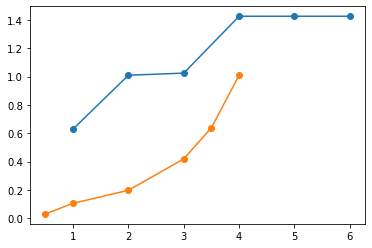

In [24]:
import matplotlib.pyplot as plt

# Max pair bkdwn pts "by hand"
res_max = {0.5: 0.03, 1:0.105, 2:0.197, 3:0.419, 3.5:0.639, 4:1.01}

res_erm = dict()
for eps in range(1,7):
    budget = get_budget_erm_attack(p, all_ranks, k=eps)
    p_tilde = get_proba_attack_erm(p, eps=budget+1e-2, dict_dist=dict_dist)
    pair_tilde = pairwise_proba(all_ranks, p_tilde)
    dist_pair = np.sum( np.abs( np.array(list(pair.values()))-np.array(list(pair_tilde.values())) ) )
    res_erm[eps] = dist_pair
    idx_sigma_tilde = (p_tilde @ K).argmin()
    sigma_tilde = all_ranks[idx_sigma_tilde]
    print(f"adv_median eps {res_erm[eps]} = {sigma_tilde}")

plt.plot(res_erm.keys(), res_erm.values(), "o-")
plt.plot(res_max.keys(), np.array(list(res_max.values())), "o-")
#plt.xlim([-0.1,6.1])
#plt.ylim([-0.05,1.05])
plt.show()

## Robustness @ 1 vs perf

For several values of thresholds

In [98]:
t = 0.2
pair = {"p_0_1":0.625, "p_0_2":0.714, "p_0_3":0.833, "p_1_2":0.6, "p_1_3":0.75, "p_2_3":0.67}

P = dict_custom_to_numpy(pair, n=4)
print(P)
Q = maxpair(P, threshold = t)
res = numpy_to_custom_dict(Q)
res = get_complete_pairwise_dict(res)
res = clean_dict(res)
read_res = get_readable_res(res)
read_res

[[0.5   0.625 0.714 0.833]
 [0.375 0.5   0.6   0.75 ]
 [0.286 0.4   0.5   0.67 ]
 [0.167 0.25  0.33  0.5  ]]
[0, 1, 2, 3]


'0=1 > 2=3'

In [94]:
# Accuracy of the median wrt the clean distrib
p_star = sigma
idxs_star = idx_rank([p_star], all_ranks)
p_star = get_proba_idxs(idxs_star)

accuracy_erm = eval_accuracy(p_star, p, K, all_ranks, n=4)
accuracy_erm

1.8107142857142857

In [101]:
# Accuracy of the max pair median wrt the clean distrib
ts = np.linspace(0,0.5,21)
accuracy_max_list = list()
for t in ts:
    Q = maxpair(P, threshold = t)
    res = numpy_to_custom_dict(Q)
    res = get_complete_pairwise_dict(res)
    res = clean_dict(res)
    accuray_max = eval_accuracy(res, p, K, all_ranks, n=4)
    accuracy_max_list.append(accuray_max)

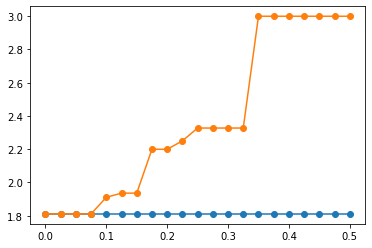

In [102]:
plt.plot(ts, len(ts)*[accuracy_erm], "o-")
plt.plot(ts, accuracy_max_list, "o-")
plt.show()

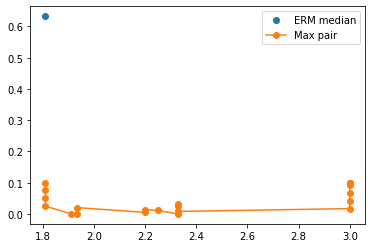

In [130]:
plt.plot(accuracy_erm, list(res_erm.values())[0], "o", label="ERM median")
plt.plot(accuracy_max_list, robustness_1_max, "o-", label="Max pair")
plt.legend()
plt.show()

In [112]:
M = np.triu(P,1)
robustness_1_max = list()
for t in ts:
    test_m = np.minimum(np.min((M-0.5)[M != 0]), np.min(np.abs(M-0.5-t)[M!=0]))
    robustness_1_max.append(test_m)

# Still exploring (optimal) attack for max pair

In [87]:
t = 0.2
pair = {"p_0_1":0.625, "p_0_2":0.714, "p_0_3":0.833, "p_1_2":0.6, "p_1_3":0.75, "p_2_3":0.67}

P = dict_custom_to_numpy(pair, n=4)
print(P, "\n\n")

M = np.triu(P,1)
print(M, "\n\n")

Q = maxpair(P, threshold = t)
res = numpy_to_custom_dict(Q)
res = get_complete_pairwise_dict(res)
res = clean_dict(res)
read_res = get_readable_res(res)
read_res

[[0.5   0.625 0.714 0.833]
 [0.375 0.5   0.6   0.75 ]
 [0.286 0.4   0.5   0.67 ]
 [0.167 0.25  0.33  0.5  ]] 


[[0.    0.625 0.714 0.833]
 [0.    0.    0.6   0.75 ]
 [0.    0.    0.    0.67 ]
 [0.    0.    0.    0.   ]] 


[0, 1, 2, 3]


'0=1 > 2=3'

In [86]:
t = 0.2
pair = {"p_0_1":0.625, "p_0_2":0.714, "p_0_3":0.833, "p_1_2":0.6, "p_1_3":0.75, "p_2_3":0.67}
P = dict_custom_to_numpy(pair, n=4)
M = np.triu(P,1)
print(M)

Q = maxpair(P, threshold = t)
res = numpy_to_custom_dict(Q)
res = get_complete_pairwise_dict(res)
res = clean_dict(res)
read_res = get_readable_res(res)
read_res

[[0.    0.625 0.699 0.833]
 [0.    0.    0.6   0.75 ]
 [0.    0.    0.    0.67 ]
 [0.    0.    0.    0.   ]]
[0, 1, 2, 3]


'0=1=2 > 3'

In [345]:
# Max pair algo with erm attack
t = 0.2
eps_list = [0.03, 0.10, 0.2, 0.42]

for eps in eps_list:
    p_tilde = get_proba_attack_erm(p, eps=eps)
    
    idx_sigma_tilde = (p_tilde @ K).argmin()
    sigma_tilde = all_ranks[idx_sigma_tilde]
    
    pair_tilde = pairwise_proba(all_ranks, p_tilde)
    P_tilde = dict_custom_to_numpy(pair_tilde, n=4)
    Q_tilde = maxpair(P_tilde, threshold = t)
    res = numpy_to_custom_dict(Q_tilde)
    res = get_complete_pairwise_dict(res)
    res = clean_dict(res)
    read_res = get_readable_res(res)
    
    print(f"eps = {eps}; adv_median eps = {sigma_tilde}; max_pair optimum = {read_res}")



eps = 0.03; adv_median eps = [0 1 2 3]; max_pair optimum = 0=1=2 > 3
eps = 0.1; adv_median eps = [0 1 2 3]; max_pair optimum = 0 > 1=2=3
eps = 0.2; adv_median eps = [0 2 1 3]; max_pair optimum = 0=2 > 1=3
eps = 0.42; adv_median eps = [2 1 0 3]; max_pair optimum = 0=1=2=3


In [25]:
w = [0.48305085, 0.31355932, 0.1440678,  0.05932203]
results = dict()

# Real solution
p = proba_plackett_luce(w, all_ranks)
pair_dict_origin = pairwise_proba(all_ranks, p, n_items=4)
print(f"Solution of real distance pb")
best_distrib, val = depth_metric_optim(p, list_bucket, all_ranks, printer=False, norm=norm)
d_ = pairwise_proba(all_ranks, best_distrib, n_items=4)
d_real_solution = get_complete_pairwise_dict(d_)
d_real_solution = clean_dict(d_real_solution)
readable_real_solution = get_readable_res(d_real_solution)
print(f"Pairise solution \n {d_real_solution}")
print(f"\n")
results["real"] = readable_real_solution


# Merging algo
threshold_val = 0.25
print(f"Solution of merging pb")
dict_pairwise = pairwise_proba(all_ranks, p)
new_dict_ = merging_algo(threshold_val, dict_pairwise)
new_dict = dict()
for key in new_dict_.keys():
    if new_dict_[key] > 0.5:
        new_dict[key] = 1.0
    elif new_dict_[key] < 0.5:
        new_dict[key] = 0.0
    elif new_dict_[key] == 0.5:
        new_dict[key] = 0.5
d_merging_solution = get_complete_pairwise_dict(new_dict)
d_merging_solution = clean_dict(d_merging_solution)
readable_merging_solution = get_readable_res(d_merging_solution)
print(f"\n")
results[str(threshold_val)] = readable_merging_solution

results

Solution of real distance pb
Optimal solution for depth metric pb: [[0.16666667 0.         0.16666667 0.         0.         0.
  0.16666667 0.         0.16666667 0.         0.         0.
  0.16666667 0.         0.16666667 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]]
[0, 1, 2, 3]
Pairise solution 
 {'p_0_1': 0.5, 'p_0_2': 0.5, 'p_0_3': 0.9999999999999999, 'p_1_2': 0.5, 'p_1_3': 0.9999999999999999, 'p_2_3': 0.9999999999999999}


Solution of merging pb
Pairwise dict: {'p_0_1': 0.6063829815278405, 'p_0_2': 0.7702702670379838, 'p_0_3': 0.8906250069140624, 'p_1_2': 0.6851851787105625, 'p_1_3': 0.8409090988326448, 'p_2_3': 0.7083333517708333}
Value closest to 0.5: 0.6063829815278405 (0.10638298152784054)
Merging items ['0', '1'] in the same bucket, key: p_0_1
pair1=p_0_2
pair2=p_1_2
item2=2, pair1=p_0_2 and pair2=p_1_2
pair1=p_0_3
pair2=p_1_3
item2=3, pair1=p_0_3 and pair2=p_1_3
pair1=p_0_2
pair2=p_1_2
item2=2, pair1=p_0_2 and pair2=p_1_2
pair

{'real': '0=1=2 > 3', '0.25': '0=1 > 2=3'}

In [26]:
def dict_custom_to_numpy(dico, n=4):
    M = np.eye(n) / 2
    for k,v in dico.items():
        _, i, j = k.split('_')
        M[int(i), int(j)] = v
        M[int(j), int(i)] = 1-v
    return M

def numpy_to_custom_dict(Q):
    dico = {}
    n = Q.shape[0]
    for i in np.arange(n):
        for j in np.arange(i+1, n):
            dico['p_'+str(i)+'_'+str(j)] = Q[i,j]
    return dico

In [27]:
def get_proba_from_pairwise(pairwise):
    if isinstance(pairwise, np.ndarray):
        M = pairwise
    elif isinstance(pairwise, dict):
        M = dict_custom_to_numpy(pairwise)
    else:
        print("Not implemented")
    
    scores = dict()
    for i in range(4):
        scores[i] = np.sum(M[i,:])
    res = sorted(scores, key=scores.get)[::-1]
    
    final_res = [res]
    for t1 in range(4):
        for t2 in range(t1+1,4):
            res_ = res
            if M[res[t1],res[t2]] == 0.5:
                min_ = np.minimum(res[t2], res[t1])
                max_ = np.maximum(res[t2], res[t1])
                perms_ = list(itertools.permutations(list(np.arange(min_, max_+1))))
                for perm_ in perms_:
                    perm_ = list(perm_)
                    add = res[:t1] + perm_ + res[t2+1:]
                    if add not in final_res:
                        final_res.append(add)
    return final_res

In [28]:
def eval_accuracy(p_star, p, L, all_ranks, n=4):
    
    if (isinstance(p_star, dict)) or (isinstance(p_star, np.ndarray) and p_star.shape == (n,n)):
        perms_star = get_proba_from_pairwise(p_star)
        idxs_star = idx_rank(perms_star, all_ranks)
        p_star = get_proba_idxs(idxs_star)
        
    if (isinstance(p, dict)) or (isinstance(p, np.ndarray) and p.shape == (n,n)):
        perms = get_proba_from_pairwise(p)
        idxs = idx_rank(perms, all_ranks)
        p = get_proba_idxs(idxs)
                
    return (p*L*p_star.T)[0,0]

In [29]:
print(d_merging_solution)
eval_accuracy(d_merging_solution, p, K, all_ranks, n=4)

{'p_0_2': 1.0, 'p_1_2': 1.0, 'p_0_3': 1.0, 'p_1_3': 1.0, 'p_0_1': 0.5, 'p_2_3': 0.5}


1.9179158929376374

### Robustness for max merge

In [30]:
def get_readable_res(pairwise_dict):
    r_items = {0:0, 1:0, 2:0, 3:0}
    for item in range(4):
        for key in pairwise_dict.keys():
            item1, item2 = key.split('_')[1], key.split('_')[2]
            if (item == int(item1)) and  pairwise_dict[key] > 0.5:
                r_items[item] +=1
            elif (item == int(item2)) and  pairwise_dict[key] < 0.5:
                r_items[item] +=1
            elif ((item == int(item1)) or (item == int(item2))) and  pairwise_dict[key] == 0.5:
                r_items[item] += 0.5
    r_list = sorted(r_items, key=lambda k:r_items[k], reverse=True)
    m = str(r_list[0])
    for i in range(1,4):
        if r_items[r_list[i-1]] > r_items[r_list[i]]:
            m += " > "
            m += str(r_list[i])
        elif r_items[r_list[i-1]] == r_items[r_list[i]]:
            m += "="
            m += str(r_list[i])
    return m

In [31]:
t = 0.71 - 0.5
pairwise_test = {"p_0_1":0.55, "p_0_2":0.7, "p_0_3":0.705, "p_1_2":0.6, "p_1_3":0.75, "p_2_3":0.65}

def get_res(pairwise, t):
    P_test = dict_custom_to_numpy(pairwise, n=4)
    print(P_test)

    Q_test = maxpair(P_test, threshold = t)
    q_pairwise_test = numpy_to_custom_dict(Q_test)
    q_pairwise_test = get_complete_pairwise_dict(q_pairwise_test)
    q_pairwise_test = clean_dict(q_pairwise_test)
    read_test = get_readable_res(q_pairwise_test)
    print(read_test)
    return q_pairwise_test

def get_distance_res(pairwise1, pairwise2):
    dist = 0
    for key in pairwise1.keys():
        if pairwise1[key] > 0.5:
            val1 = 1
        elif pairwise1[key] == 0.5:
            val1 = 0.5
        elif pairwise1[key] < 0.5:
            val1 = 0
        if pairwise2[key] > 0.5:
            val2 = 1
        elif pairwise2[key] == 0.5:
            val2 = 0.5
        elif pairwise2[key] < 0.5:
            val2 = 0
        dist += np.abs(val1-val2)
    return dist

In [93]:
res_test = get_res(pairwise_test, t)

[[0.5   0.55  0.7   0.705]
 [0.45  0.5   0.6   0.75 ]
 [0.3   0.4   0.5   0.65 ]
 [0.295 0.25  0.35  0.5  ]]
0=1=2 > 3


In [55]:
t = 0.71
a = 0.73

np.maximum(np.abs(a-t),0)

for i in range(4):
    for j in range(i+1,4):
        print(i,j)
        r1 = res_test

0.020000000000000018

In [299]:
pairwise_att = {"p_0_1":0.55, "p_0_2":0.72, "p_0_3":0.8, "p_1_2":0.6, "p_1_3":0.75, "p_2_3":0.65}
get_res(pairwise_att, t)

[[0.5  0.55 0.72 0.8 ]
 [0.45 0.5  0.6  0.75]
 [0.28 0.4  0.5  0.65]
 [0.2  0.25 0.35 0.5 ]]
0=1 > 2=3


{'p_0_1': 0.5,
 'p_0_2': 1.0,
 'p_0_3': 1.0,
 'p_1_2': 1.0,
 'p_1_3': 1.0,
 'p_2_3': 0.5}

In [152]:
get_distance_res(res_test, res_att)

1.0

In [37]:
mat = np.matrix([[1,1,0,0,1,0],[1,1,1,0,0,0],[1,0,1,1,0,0]])
p = np.matrix([0.4, 0.2, 0.1, 0.1, 0.15, 0.05]).T

eps = 0.25
p_att = p + np.matrix([-eps/2, eps/2, 0,0,0,0]).T

pair = mat*p
pair_att = mat*p_att

print(pair)
print(f"\n")
print(pair_att)

[[0.75]
 [0.7 ]
 [0.6 ]]


[[0.75 ]
 [0.7  ]
 [0.475]]


In [38]:
matinv = np.linalg.pinv(mat)
p_res = matinv*pair
p_res_att = matinv*pair_att

print(p_res)
print(f"\n")
print(p_res_att)

[[0.3375 ]
 [0.21875]
 [0.14375]
 [0.11875]
 [0.19375]
 [0.     ]]


[[0.30625 ]
 [0.265625]
 [0.128125]
 [0.040625]
 [0.178125]
 [0.      ]]


In [39]:
np.linalg.norm(np.squeeze(np.asarray(p_res))-np.squeeze(np.asarray(p_res_att)), 1)

0.18750000000000014

In [40]:
#p_att_test = p_att + (p_res_att - p_res)
mat*(p_res_att)

matrix([[0.75 ],
        [0.7  ],
        [0.475]])

In [43]:
from sympy import *
#print(matinv, p_res)
#test = np.concatenate((matinv, p_res), axis=1)
test = np.matrix([[1,1,0,0,1,0,0.75],[1,1,1,0,0,0,0.7],[1,0,1,1,0,0,0.475],[1,1,1,1,1,1,1]])
print(test)

Test = Matrix(test)
t = Test.rref()[0]
M = t[:,:6]
y = t[:,6]
t

M2 = np.matrix(M)
y2 = np.matrix(y)

[[1.    1.    0.    0.    1.    0.    0.75 ]
 [1.    1.    1.    0.    0.    0.    0.7  ]
 [1.    0.    1.    1.    0.    0.    0.475]
 [1.    1.    1.    1.    1.    1.    1.   ]]


In [44]:
print(M)
print(y)

Matrix([[1, 0, 0, 0, 0, -1.00000000000000], [0, 1, 0, 0, 1.00000000000000, 1.00000000000000], [0, 0, 1, 0, -1.00000000000000, 0], [0, 0, 0, 1, 1.00000000000000, 1.00000000000000]])
Matrix([[0.225000000000000], [0.525000000000000], [-0.0500000000000000], [0.300000000000000]])


In [45]:
import cvxpy as cvx

x = cvx.Variable((6,1)) #b is dim x

objective = cvx.Minimize(cvx.norm(p-x,1)) #L_1 norm objective function
constraints = [M2*x == y2,
              x >= 0,
              x <= 1] #y is dim a and M is dim a by b
prob = cvx.Problem(objective,constraints)
result = prob.solve(verbose=False)

/Users/m.goibert/miniforge3/lib/python3.9/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


In [46]:
x.value

array([[0.32491024],
       [0.27508976],
       [0.1       ],
       [0.05008976],
       [0.15      ],
       [0.09991024]])

In [47]:
p

matrix([[0.4 ],
        [0.2 ],
        [0.1 ],
        [0.1 ],
        [0.15],
        [0.05]])

In [48]:
np.linalg.norm(np.squeeze(np.asarray(p))-np.squeeze(np.asarray(x.value)), 1)

0.2500000000004262

In [32]:
def optimal_distrib_from_pairwise(p, pairwise):
    M = np.matrix([
        [1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,0,1,0],
        [1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0],
        [1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0],
        [1,1,0,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,0],
        [1,1,1,0,0,0,1,1,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0],
        [1,0,1,1,0,0,1,0,1,1,0,0,1,1,1,1,1,1,0,0,0,0,0,0],
        [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    ])
    if isinstance(pairwise, dict):
        pairwise_ = np.matrix(list(pairwise.values()))
    else:
        pairwise_ = pairwise
    y = np.concatenate((pairwise_, np.matrix([[1]])), axis=1)
    
    x = cvx.Variable((24,1)) #b is dim x
    objective = cvx.Minimize(cvx.norm(p-x,1)) #L_1 norm objective function
    constraints = [M@x == y,
                  x >= 0,
                  x <= 1] #y is dim a and M is dim a by b
    prob = cvx.Problem(objective,constraints)
    result = prob.solve(verbose=False)
    return x.value

In [121]:
t = 0.2

print(p)
pairwise = pairwise_proba(all_ranks, p, n_items=4)
res_origin = get_res(pairwise, t)
pairwise_att = {"p_0_1":0.606, "p_0_2":0.770, "p_0_3":0.890, "p_1_2":0.685, "p_1_3":0.841, "p_2_3":0.708}
res_att = get_res(pairwise_att, t)
res_att

p_att = optimal_distrib_from_pairwise(p, pairwise_att)
print(p_att)
np.linalg.norm(p-p_att, 1)

[[0.2075403  0.08545776 0.1132038  0.02141693 0.03798123 0.01745083
  0.15629578 0.06435708 0.05861092 0.00719783 0.02087257 0.00622515
  0.06837061 0.01293498 0.04700479 0.00577252 0.00605467 0.00393023
  0.02087257 0.0095901  0.01523133 0.00454268 0.00550921 0.00357615]]
[[0.5        0.60638298 0.77027027 0.89062501]
 [0.39361702 0.5        0.68518518 0.8409091 ]
 [0.22972973 0.31481482 0.5        0.70833335]
 [0.10937499 0.1590909  0.29166665 0.5       ]]
0 > 1=2 > 3
[[0.5   0.606 0.77  0.89 ]
 [0.394 0.5   0.685 0.841]
 [0.23  0.315 0.5   0.708]
 [0.11  0.159 0.292 0.5  ]]
0 > 1=2 > 3
None


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [33]:
def set_ranks_pairwise(all_ranks, item_better, item_worse):
    res = list()
    for rank in all_ranks:
        rk_better = int(np.argwhere(rank == item_better))
        rk_worse = int(np.argwhere(rank == item_worse))
        if rk_better < rk_worse:
            res.append(rank)
    return res

def attack_maxpair(p, t, eps, all_ranks):
    if eps == None:
        return p

    pairwise = pairwise_proba(all_ranks, p, n_items=4)
    P = dict_custom_to_numpy(pairwise, n=4)
    M = np.triu(P,1)
    M[M==0.0] = np.inf

    diff_inv = np.abs(M-0.5+t)
    idx_inv = np.transpose(np.unravel_index(np.argsort(np.abs(M-0.5+t), axis=None), M.shape)).tolist()[:6]
    idx_inv2 = np.argwhere(np.abs(M-0.5+t) < eps)
    idx_inv2 = [list(idx) for idx in idx_inv2]
    idx_inv_eps = [idx for idx in idx_inv if idx in idx_inv2]

    diff_thres = np.abs(M-0.5-t)
    idx_thres = np.transpose(np.unravel_index(np.argsort(np.abs(M-0.5-t), axis=None), M.shape)).tolist()[:6]
    idx_thres2 = np.argwhere(np.abs(M-0.5-t) < eps)
    idx_thres2 = [list(idx) for idx in idx_thres2]
    idx_thres_eps = [idx for idx in idx_thres if idx in idx_thres2]
    
    common_idxs = [idxs for idxs in idx_inv_eps if idxs in idx_thres_eps]
    for common_idx in common_idxs:
        if (M-0.5+t)[common_idx[0],common_idx[1]] * (M-0.5-t)[common_idx[0],common_idx[1]] > 0:
            # That's ok
            idx_inv_eps.remove(common_idx)
        else:
            if np.abs((M-0.5+t)[common_idx[0],common_idx[1]]) < np.abs((M-0.5-t)[common_idx[0],common_idx[1]]):
                idx_thres_eps.remove(common_idx)
            elif np.abs((M-0.5+t)[common_idx[0],common_idx[1]]) > np.abs((M-0.5-t)[common_idx[0],common_idx[1]]):
                idx_inv_eps.remove(common_idx)

    r = all_ranks
    for i_inv, j_inv in idx_inv_eps:
        if (M-0.5+t)[i_inv, j_inv] > 0:
            r = set_ranks_pairwise(r, j_inv, i_inv)
        else:
            r = set_ranks_pairwise(r, i_inv, j_inv)
        if len(r) < 2:
            break
    for i_thres, j_thres in idx_thres_eps:
        if (M-0.5-t)[i_thres, j_thres] > 0:
            r = set_ranks_pairwise(r, j_thres, i_thres)
        else:
            r = set_ranks_pairwise(r, i_thres, j_thres)
        if len(r) < 2:
            break
            
    r_inv = [r_[::-1] for r_ in r]
    p_att = p + eps/2 * bucket_distrib(all_ranks, r) - eps/2*bucket_distrib(all_ranks, r_inv)
    return p_att


def get_budget_attack_maxpair(p, t, all_ranks):
    pairwise = pairwise_proba(all_ranks, p, n_items=4)
    res = get_res(pairwise, t)
    P = dict_custom_to_numpy(pairwise, n=4)
    M = np.triu(P,1)
    M[M==0.0] = np.inf
    diff_inv = np.abs(M-0.5+t)
    diff_thres = np.abs(M-0.5-t)
    
    diff_tot = np.concatenate((diff_inv[diff_inv != np.inf], diff_thres[diff_thres != np.inf]))
    diff_tot = np.unique(np.sort(2*diff_tot))
    print(f"diff_tot={diff_tot}")
    dist_maxpair = 0
    k = -1
    while dist_maxpair == 0:
        k += 1
        if k >= len(diff_tot):
            eps = None
            break
        eps = diff_tot[k]+1e-5
        p_att = attack_maxpair(p=p, t=t, eps=eps, all_ranks=all_ranks)
        pairwise_att = pairwise_proba(all_ranks, p_att, n_items=4)
        res_att = get_res(pairwise_att, t)
        dist_maxpair = get_distance_res(res, res_att)
    return eps

In [502]:
w = np.array([25, 8, 3, 2.5])
p = proba_plackett_luce(w, all_ranks)
pairwise = pairwise_proba(all_ranks, p, n_items=4)
print(p)
print(p*K)
print(pairwise)

[[0.20989112 0.17490927 0.10994297 0.03435718 0.08745463 0.03279549
  0.09290263 0.07741886 0.01858053 0.00185805 0.01520728 0.00182487
  0.0418093  0.01306541 0.01596355 0.00159635 0.00415717 0.0013303
  0.03279549 0.01229831 0.01288394 0.00154607 0.00409944 0.00131182]]
[[1.40584416 1.49675325 1.86038961 2.38419913 2.02056277 2.47510823
  1.92099567 2.01190476 2.70670996 3.52489177 2.83008658 3.61580087
  2.6461039  3.16991342 3.16125541 3.97943723 3.98809524 4.50324675
  2.83874459 3.29329004 3.3538961  4.13961039 4.07900433 4.59415584]]
{'p_0_1': 0.7575757575757573, 'p_0_2': 0.8928571428571426, 'p_0_3': 0.9090909090909088, 'p_1_2': 0.727272727272727, 'p_1_3': 0.7619047619047616, 'p_2_3': 0.5454545454545455}


In [503]:
t = 0.2
eps = 0.1

# Clean res
pairwise = pairwise_proba(all_ranks, p, n_items=4)
res = get_res(pairwise, t)

# Attack maxpair
p_att = attack_maxpair(p, t, eps, all_ranks)
pairwise_att = pairwise_proba(all_ranks, p_att, n_items=4)
res_att = get_res(pairwise_att, t)
print(res_att)

# Comparison results
dist = np.linalg.norm(np.squeeze(np.asarray(p))-np.squeeze(np.asarray(p_att)), 1)
print(dist)


dist_maxpair = get_distance_res(res, res_att)
print(dist_maxpair)

[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.10714286 0.27272727 0.5        0.54545455]
 [0.09090909 0.23809524 0.45454545 0.5       ]]
0 > 1 > 2=3
[[0.5        0.70757576 0.84285714 0.85909091]
 [0.29242424 0.5        0.67727273 0.71190476]
 [0.15714286 0.32272727 0.5        0.54545455]
 [0.14090909 0.28809524 0.45454545 0.5       ]]
0 > 1=2 > 3
{'p_0_1': 1.0, 'p_0_2': 1.0, 'p_0_3': 1.0, 'p_1_2': 0.5, 'p_1_3': 1.0, 'p_2_3': 1.0}
0.09999999999999998
1.0


Threshold=0.0
Diff p and p_att = [[-0.00416667  0.00416667 -0.00416667 -0.00416667  0.00416667  0.00416667
  -0.00416667  0.00416667 -0.00416667 -0.00416667  0.00416667  0.00416667
  -0.00416667 -0.00416667 -0.00416667 -0.00416667 -0.00416667 -0.00416667
   0.00416667  0.00416667  0.00416667  0.00416667  0.00416667  0.00416667]]
[[0.5        0.75757576 0.90952381 0.89242424]
 [0.24242424 0.5        0.74393939 0.7452381 ]
 [0.09047619 0.25606061 0.5        0.49545455]
 [0.10757576 0.2547619  0.50454545 0.5       ]]
0 > 1 > 3 > 2
Threshold=0.025
Diff p and p_att = [[-0.00416667  0.00416667 -0.00416667 -0.00416667  0.00416667  0.00416667
  -0.00416667  0.00416667 -0.00416667 -0.00416667  0.00416667  0.00416667
  -0.00416667 -0.00416667 -0.00416667 -0.00416667 -0.00416667 -0.00416667
   0.00416667  0.00416667  0.00416667  0.00416667  0.00416667  0.00416667]]
[[0.5        0.75757576 0.90952381 0.89242424]
 [0.24242424 0.5        0.74393939 0.7452381 ]
 [0.09047619 0.25606061 0.5        0.49

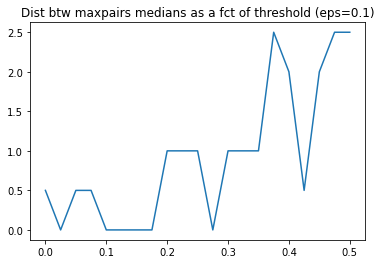

In [504]:
eps = 0.1

ts = np.linspace(0,0.5,21)
dist_maxpairs = list()
for t in ts:
    print(f"Threshold={t}")
    p_att = attack_maxpair(p, t, eps, all_ranks)
    print(f"Diff p and p_att = {p_att - p}")
    pairwise_att = pairwise_proba(all_ranks, p_att, n_items=4)
    res_att = get_res(pairwise_att, t)
    dist_maxpair = get_distance_res(res, res_att)
    dist_maxpairs.append(dist_maxpair)

plt.plot(ts, dist_maxpairs)
plt.title(f"Dist btw maxpairs medians as a fct of threshold (eps={eps})")
plt.show()

0.0
[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.10714286 0.27272727 0.5        0.54545455]
 [0.09090909 0.23809524 0.45454545 0.5       ]]
0 > 1 > 2=3
0.01
[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.10714286 0.27272727 0.5        0.54545455]
 [0.09090909 0.23809524 0.45454545 0.5       ]]
0 > 1 > 2=3
0.02
[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.10714286 0.27272727 0.5        0.54545455]
 [0.09090909 0.23809524 0.45454545 0.5       ]]
0 > 1 > 2=3
0.03
[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.10714286 0.27272727 0.5        0.54545455]
 [0.09090909 0.23809524 0.45454545 0.5       ]]
0 > 1 > 2=3
0.04
[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.10714286 0.27272727 0.5        0.54545455]
 [0.09090909 0.23809524 0.45454

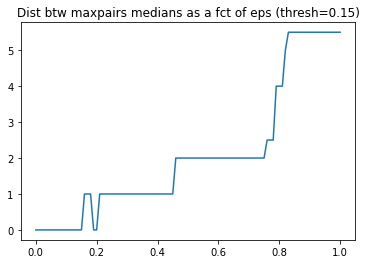

In [505]:
t = 0.15

epss = np.linspace(0,1,101)
dist_maxpairs = list()
for eps in epss:
    print(eps)
    p_att = attack_maxpair(p, t, eps, all_ranks)
    pairwise_att = pairwise_proba(all_ranks, p_att, n_items=4)
    res_att = get_res(pairwise_att, t)
    dist_maxpair = get_distance_res(res, res_att)
    dist_maxpairs.append(dist_maxpair)

plt.plot(epss, dist_maxpairs)
plt.title(f"Dist btw maxpairs medians as a fct of eps (thresh={t})")
plt.show()

In [554]:
# Accuracy of the median wrt the clean distrib
sigma = np.array([0.,1.,2.,3.])
p_star = sigma
idxs_star = idx_rank([p_star], all_ranks)
p_star = get_proba_idxs(idxs_star)

accuracy_erm = eval_accuracy(p_star, p, K, all_ranks, n=4)
print(accuracy_erm)

# Accuracy of the max pair median wrt the clean distrib
ts = np.linspace(0,0.5,101) #list_thresholds
accuracy_max_list = list()
for t in ts:
    Q = maxpair(P, threshold = t)
    res = numpy_to_custom_dict(Q)
    res = get_complete_pairwise_dict(res)
    res = clean_dict(res)
    accuray_max = eval_accuracy(res, p, K, all_ranks, n=4)
    accuracy_max_list.append(accuray_max)
print(accuracy_max_list)

1.405844155844156
[1.405844155844156, 1.405844155844156, 1.405844155844156, 1.405844155844156, 1.405844155844156, 1.405844155844156, 1.405844155844156, 1.405844155844156, 1.405844155844156, 1.405844155844156, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.4512987012987013, 1.6331168831168834, 1.6331168831168834, 1.6331168831168834, 1.633116883

In [555]:
dict_dist = get_dist_dict(sigma)
res_erm = dict()

for k in range(1,7):
    eps = get_budget_erm_attack(p, all_ranks, k=k)
    p_tilde = get_proba_attack_erm(p, eps=(eps+1e-10), dict_dist=dict_dist)    
    sigma_tilde_star = (p_tilde * K).argmin()
    p_tilde_star = get_proba_idxs([sigma_tilde_star])
    dist_erm = (p_star @ K @ p_tilde_star.T)[0][0]
    print(f"Adv sigma star for k={k} (eps={eps}) --> {all_ranks[sigma_tilde_star]} (dist={dist_erm})")
    res_erm[k] = eps
    idx_sigma_tilde = (p_tilde @ K).argmin()
    sigma_tilde = all_ranks[idx_sigma_tilde]
    print(f"adv_median eps {res_erm[k]} = {sigma_tilde}")

ts = np.linspace(0,0.5,101) #list_thresholds
rob_maxpair_list = list()
dists_maxpair = list()
for t in ts:
    print(f"\n\nt = {t}\n\n")
    res = get_res(pairwise, t)
    rob_maxpair = get_budget_attack_maxpair(p, t, all_ranks)
    p_att = attack_maxpair(p, t, rob_maxpair, all_ranks)
    pairwise_att = pairwise_proba(all_ranks, p_att, n_items=4)
    res_att = get_res(pairwise_att, t)
    dist_maxpair = get_distance_res(res, res_att)
    print(f"t = {t}, res={res} eps = {rob_maxpair} and dist = {dist_maxpair}")
    dists_maxpair.append(dist_maxpair)
    if dist_maxpair < 0.5:
        rob_maxpair_list.append(1)
    else:
        rob_maxpair_list.append(rob_maxpair)


Adv sigma star for k=1 (eps=0.09090909090909105) --> [0 1 3 2] (dist=1.0)
adv_median eps 0.09090909090909105 = [0 1 3 2]
Adv sigma star for k=2 (eps=0.48917748917748904) --> [0 3 2 1] (dist=3.0)
adv_median eps 0.48917748917748904 = [0 3 2 1]
Adv sigma star for k=3 (eps=0.48917748917748904) --> [0 3 2 1] (dist=3.0)
adv_median eps 0.48917748917748904 = [0 3 2 1]
Adv sigma star for k=4 (eps=0.670995670995671) --> [0 3 2 1] (dist=3.0)
adv_median eps 0.670995670995671 = [0 3 2 1]
Adv sigma star for k=5 (eps=0.7063492063492062) --> [3 2 1 0] (dist=6.0)
adv_median eps 0.7063492063492062 = [3 2 1 0]
Adv sigma star for k=6 (eps=0.7063492063492065) --> [3 2 1 0] (dist=6.0)
adv_median eps 0.7063492063492065 = [3 2 1 0]


t = 0.0


[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.10714286 0.27272727 0.5        0.54545455]
 [0.09090909 0.23809524 0.45454545 0.5       ]]
0 > 1 > 2 > 3
[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5    

diff_tot=[0.01619048 0.02484848 0.08545455 0.24571429 0.27818182 0.44909091
 0.63090909 0.99454545 1.05515152 1.06380952 1.32571429 1.35818182]
[[0.5        0.765676   0.89690726 0.91719115]
 [0.234324   0.5        0.72727273 0.770005  ]
 [0.10309274 0.27272727 0.5        0.54950466]
 [0.08280885 0.229995   0.45049534 0.5       ]]
0=1 > 2=3
[[0.5        0.765676   0.89690726 0.91719115]
 [0.234324   0.5        0.72727273 0.770005  ]
 [0.10309274 0.27272727 0.5        0.54950466]
 [0.08280885 0.229995   0.45049534 0.5       ]]
0=1 > 2=3
t = 0.27, res={'p_0_1': 1.0, 'p_0_2': 1.0, 'p_0_3': 1.0, 'p_1_2': 0.5, 'p_1_3': 0.5, 'p_2_3': 0.5} eps = 0.016200476190476754 and dist = 1.5


t = 0.275


[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.10714286 0.27272727 0.5        0.54545455]
 [0.09090909 0.23809524 0.45454545 0.5       ]]
0 > 1=2=3
[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.107142

 [0.044995   0.22661672 0.45454545 0.5       ]]
0=1=2 > 3
t = 0.455, res={'p_0_1': 0.5, 'p_0_2': 0.5, 'p_0_3': 0.5, 'p_1_2': 0.5, 'p_1_3': 0.5, 'p_2_3': 0.5} eps = 0.09182818181818235 and dist = 1.5


t = 0.46


[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.10714286 0.27272727 0.5        0.54545455]
 [0.09090909 0.23809524 0.45454545 0.5       ]]
0=1=2=3
[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.10714286 0.27272727 0.5        0.54545455]
 [0.09090909 0.23809524 0.45454545 0.5       ]]
0=1=2=3
diff_tot=[0.10181818 0.13428571 0.39619048 0.40484848 0.46545455 0.82909091
 1.01090909 1.37454545 1.43515152 1.44380952 1.70571429 1.73818182]
[[0.5        0.7830328  0.94377123 0.960005  ]
 [0.2169672  0.5        0.74000125 0.77463328]
 [0.05622877 0.25999875 0.5        0.54545455]
 [0.039995   0.22536672 0.45454545 0.5       ]]
0=1=2 > 3
[[0.5        0.7830328  0.94377123 0.960005  ]
 [0.

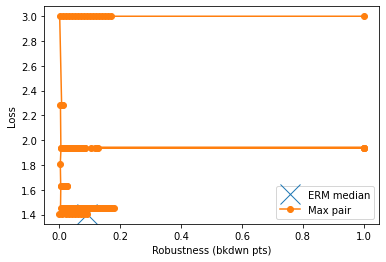

In [556]:
plt.plot(list(res_erm.values())[0], accuracy_erm, "x", label="ERM median", ms=20)
plt.plot(rob_maxpair_list, accuracy_max_list, "o-", label="Max pair")
plt.legend()
plt.xlabel(f"Robustness (bkdwn pts)")
plt.ylabel(f"Loss")
#plt.xlim(0, 0.74)
#plt.ylim(1.35, 2.2)
plt.show()

In [511]:
t = 0.05
eps = 0.01

# Clean res
pairwise = pairwise_proba(all_ranks, p, n_items=4)
res = get_res(pairwise, t)

# Attack maxpair
p_att = attack_maxpair(p, t, eps, all_ranks)
pairwise_att = pairwise_proba(all_ranks, p_att, n_items=4)
res_att = get_res(pairwise_att, t)

# Comparison results
dist = np.linalg.norm(np.squeeze(np.asarray(p))-np.squeeze(np.asarray(p_att)), 1)
print(dist)


dist_maxpair = get_distance_res(res, res_att)
print(dist_maxpair)

[[0.5        0.75757576 0.89285714 0.90909091]
 [0.24242424 0.5        0.72727273 0.76190476]
 [0.10714286 0.27272727 0.5        0.54545455]
 [0.09090909 0.23809524 0.45454545 0.5       ]]
0 > 1 > 2=3
[[0.5        0.75757576 0.89119048 0.91075758]
 [0.24242424 0.5        0.72560606 0.76357143]
 [0.10880952 0.27439394 0.5        0.55045455]
 [0.08924242 0.23642857 0.44954545 0.5       ]]
0 > 1 > 2 > 3
0.010000000000000009
0.5


In [557]:
for i, t in enumerate(ts):
    print(f"{t}: {rob_maxpair_list[i]}")

0.0: 0.09091909090909105
0.005: 0.08091909090909105
0.01: 0.07091909090909104
0.015: 0.060919090909091055
0.02: 0.05091909090909105
0.025: 0.04091909090909105
0.03: 0.030919090909091052
0.035: 0.020919090909091043
0.04: 0.010919090909091048
0.045: 0.0009190909090910537
0.05: 0.009100909090908955
0.055: 0.01910090909090895
0.06: 0.029100909090908945
0.065: 0.03910090909090896
0.07: 0.049100909090908966
0.075: 0.05910090909090895
0.08: 0.06910090909090895
0.085: 0.07910090909090896
0.09: 0.08910090909090894
0.095: 0.09910090909090895
0.1: 0.10910090909090896
0.105: 0.11910090909090894
0.11: 0.12910090909090896
0.115: 0.13910090909090897
0.12: 0.14910090909090895
0.125: 0.15910090909090896
0.13: 0.16910090909090897
0.135: 0.17910090909090898
0.14: 0.1745554545454539
0.145: 0.16455545454545395
0.15: 0.15455545454545394
0.155: 0.14455545454545393
0.16: 0.13455545454545392
0.165: 0.1245554545454539
0.17: 0.11455545454545389
0.17500000000000002: 0.10455545454545388
0.18: 0.09455545454545393
0

In [550]:
M = np.triu(P,1)
val = M[M!=0]
val = np.sort(val)
print(val)
list_thresholds = list()
for i in range(val.shape[0]):
    for j in range(i+1, val.shape[0]):
        diff_val = (val[i]+val[j])/2 - 0.5
        list_thresholds.append(diff_val)
list_thresholds = np.sort(list_thresholds)
list_thresholds

[0.54545455 0.72727273 0.75757576 0.76190476 0.89285714 0.90909091]


array([0.13636364, 0.15151515, 0.15367965, 0.21915584, 0.22727273,
       0.24242424, 0.24458874, 0.25974026, 0.31006494, 0.31818182,
       0.32521645, 0.32738095, 0.33333333, 0.33549784, 0.40097403])

In [558]:
P

array([[0.5       , 0.75757576, 0.89285714, 0.90909091],
       [0.24242424, 0.5       , 0.72727273, 0.76190476],
       [0.10714286, 0.27272727, 0.5       , 0.54545455],
       [0.09090909, 0.23809524, 0.45454545, 0.5       ]])

## Smooth function L o T

In [212]:
device = "cpu"
default_tensor_type = torch.FloatTensor
from torch.distributions import MultivariateNormal
from torch.optim.lr_scheduler import LambdaLR, ConstantLR
from torch.autograd import Variable

torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

def _torch_maxpair(P, threshold = 0.):
    s = torch.sum(1*(P > 0.5)+1/2*(P == 0.5), axis=1)
    sigma = torch.argsort(-s)
    M = P[np.ix_(sigma,sigma)]
    
    idxs = torch.argwhere(M>1/2+threshold)
    for idx in idxs:
        M[:idx[0]+1,idx[1]] = 1
        M[idx[1],:idx[0]+1] = 0

    m = torch.max(torch.abs(M-0.5)*(M!=0.5)*(torch.abs(M-0.5) <= t))
    while m > 0:
        i,j = torch.argwhere(np.abs(M-0.5) == m)[0,0], torch.argwhere(np.abs(M-0.5) == m)[0,1]
        if i <= j:
            idx_tomerge1, idx_tomerge2 = i, j+1
        elif i > j:
            idx_tomerge1, idx_tomerge2 = j, i+1
        M = torch_merge_idx(M, torch.arange(idx_tomerge1,idx_tomerge2))
        m = torch.max(np.abs(M - 0.5) * (M != 0.5) * (torch.abs(M - 0.5) <= threshold))
    return M[np.ix_(torch.argsort(sigma), torch.argsort(sigma))]

def torch_maxpair(p, torch_all_ranks, n=4, threshold = 0.):
    P = torch_pairwise_matrix(p, torch_all_ranks=torch_all_ranks, n=n)
    return _torch_maxpair(P, threshold = threshold)
    
def kendall_tau(y, sigma, norm=False):
    """
    Kendall Tau distance
    Permutations follow the convention rank -> item_id
    :param torch.Tensor y: permutation
    :param torch.Tensor sigma: permutation
    :return: value of the metric
    :rtype: torch.Tensor
    """
    with torch.no_grad():
        n = sigma.size()[-1]
        sigma_inv = torch.argsort(sigma, dim=-1).to(device).type(default_tensor_type)
        y_inv = torch.argsort(y, dim=-1).to(device).type(default_tensor_type)
        sigma_pairs = (sigma_inv.unsqueeze(dim=-1) > sigma_inv.unsqueeze(dim=-2)).to(device).type(default_tensor_type)
        y_pairs = (y_inv.unsqueeze(dim=-1) > y_inv.unsqueeze(dim=-2)).to(device).type(default_tensor_type)
        res = torch.sum(torch.abs(sigma_pairs-y_pairs), dim=[-2,-1])
        if norm:
            return res/(n*(n-1))
        else:
            return res/2

def torch_pairwise_matrix(p_torch, torch_all_ranks, n=4):
    M = torch.zeros(4,4)
    for i in range(M.shape[0]):
        for j in range(i+1,M.shape[0]):
            idxs = torch.tensor([torch.argwhere(rk == i).item() < torch.argwhere(rk == j).item() for rk in torch_all_ranks])
            val = torch.sum(p_torch[0,idxs]).item()
            M[i,j] = val
            M[j,i] = 1-val
    return M

def torch_merge_idx(M, idx):
    # i,j \notin idx -> P_ij = M_ij
    # i \in idx, j \notin idx -> P_ij = \max_{k\in idx} M_kj
    # i \notin idx, j \in idx -> P_ij = \max_{k\in idx} M_ik
    # i,j \in idx -> P_ij = 0.5
    P = M
    for i in torch.arange(M.shape[0]):
        m = torch.max(M[i, idx])
        for j in idx:
            P[i,j] = m
    for j in torch.arange(M.shape[0]):
        m = torch.max(M[idx, j])
        for i in idx:
            P[i,j] = m
    for i in idx:
        for j in idx:
            P[i,j] = 0.5
    PTRIU = torch.triu(P, 0)
    P = PTRIU + torch.tril(1 - PTRIU.T, -1)
    return P

def torch_dist(P1, P2):
    return torch.norm(torch.triu(P1,1) - torch.triu(P2,1), 1)
  
def torch_dist_maxpair(p_torch1, p_torch2, torch_all_ranks, threshold):
    R1 = torch_maxpair(p_torch1, torch_all_ranks, n=4, threshold=threshold)
    R2 = torch_maxpair(p_torch2, torch_all_ranks, n=4, threshold=threshold)
    return torch_dist(R1, R2)
    
    
    

In [118]:
def smooth_pg_2(m, k_x):
    r"""
    Smooth a metric $m$ by convolution with a kernel $k_x$ centered in $x$.
    $$\tilde{m}(y,x) = \int m(y,u) k_x(u) du$$
    As the gradient is not available in closed-form, the loss build is a policy gradient loss, that leads to a noisy but
    unbiased estimate of the gradient of $\tilde{m}$.
    $$g_x(y,u) = \log(k_x(u)) f(y,u) ~~~~\text{for}~~~ u\sim k_x$$
    :param m: function to be smoothed
    :param k_x: function $x\mapsto k$ where $k$ is a kernel centered in $x$
    :return: $g_x(y,u)$ for $u\sim k_x$
    """
    def smoothed_m_pg(y, x):
        k = k_x(x)
        batch_size = torch.Size()
        if len(y.size()) > 1:
            batch_size = y.size()[:-1]
        u = k.sample(batch_size).to(device).type(default_tensor_type)
        loss = k.log_prob(u) * m(y,u)
        return loss

    return smoothed_m_pg

In [ ]:
def torch_optim_attack(p_torch, T_stat, eps):
    

In [274]:
relu = torch.nn.ReLU()

z = torch.squeeze(p_torch,0) - q
z_abs = torch.abs(z)
z_abs_sorted, b = torch.sort(z_abs, 0, descending=True)
eps = 0.002

z_cumsum = torch.cumsum(z_abs_sorted,0)
val = z_cumsum - torch.tensor([ (i+1)*z_abs_sorted[i] for i in range(z_abs.shape[0])]) < eps
lambda_ = relu(torch.dot(z_abs_sorted, val.type(torch.double)) - eps)/torch.sum(val)

z[z_abs<lambda_] = 0
test_q = p_torch-z
test_q

tensor([[0.1969, 0.0855, 0.1132, 0.0214, 0.0380, 0.0175, 0.1443, 0.0644, 0.0586,
         0.0072, 0.0209, 0.0062, 0.0573, 0.0129, 0.0470, 0.0058, 0.0061, 0.0039,
         0.0209, 0.0096, 0.0152, 0.0045, 0.0055, 0.0036]], dtype=torch.float64,
       grad_fn=<SubBackward0>)

In [251]:
for i in range(z_abs.shape[0]):
    print((i+1)*z_abs[i])

tensor(0.0107, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0048, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0006, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0004, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0052, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0007, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0843, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0021, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0841, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0026, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0133, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0010, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.1441, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0044, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0086, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0020, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor(0.0051, dtype=torch.float64, grad

In [290]:
p_torch = torch.from_numpy(p)
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))
P = torch_pairwise_matrix(p_torch, torch_all_ranks, n=4)
R = torch_maxpair(p_torch, torch_all_ranks, n=4, threshold = 0.25)
R



std_dev = 10
threshold = 0.0
epochs = 5000
eps = 0.0

regs3 = np.linspace(0,0.5, 101)
softplus = torch.nn.Softplus(beta=1, threshold=20)

eps_res = list()
loss_res = list()

for reg3 in regs3:
    print(f"reg = {reg3}")

    kernel_conv = lambda _s: MultivariateNormal(_s, std_dev * torch.eye(_s.size()[-1]))
    dist_Tp_Tq = lambda _p,_q: torch_dist_maxpair(_p, _q, torch_all_ranks, threshold=threshold)
    smoothed_dist_Tp_Tq = lambda p, q: smooth_pg_2(dist_Tp_Tq, kernel_conv)(p, q)

    s_ = p_torch[0,:].detach().clone().to(device).type(default_tensor_type)
    s_.requires_grad = True
    optimizer = torch.optim.SGD([s_], lr=0.01, momentum=0.9)
    scheduler = ConstantLR(optimizer, 0.75)


    losses = []
    dists = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        q = softplus(s_)/torch.sum(softplus(s_))
        loss = -smoothed_dist_Tp_Tq(p_torch, q) + reg3*(torch.norm(p_torch-q, 1)-eps)
        losses.append(loss.detach().numpy())
        dists.append(dist_Tp_Tq(p_torch, torch.unsqueeze(q,0)))
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    eps_res.append(torch.norm(p_torch - torch.unsqueeze(q,0),1))
    loss_res.append(torch_dist_maxpair(p_torch, torch.unsqueeze(q,0), torch_all_ranks, threshold=threshold))

    #print(q, torch.sum(q))
    #plt.plot(range(epochs), losses)
    #plt.show()

    #plt.plot(range(epochs), dists)
    #plt.show()

reg = 0.0
reg = 0.005
reg = 0.01
reg = 0.015
reg = 0.02
reg = 0.025
reg = 0.03
reg = 0.035
reg = 0.04
reg = 0.045
reg = 0.05
reg = 0.055
reg = 0.06
reg = 0.065
reg = 0.07
reg = 0.075
reg = 0.08
reg = 0.085
reg = 0.09
reg = 0.095
reg = 0.1
reg = 0.105
reg = 0.11
reg = 0.115
reg = 0.12
reg = 0.125
reg = 0.13
reg = 0.135
reg = 0.14
reg = 0.145
reg = 0.15
reg = 0.155
reg = 0.16
reg = 0.165
reg = 0.17
reg = 0.17500000000000002
reg = 0.18
reg = 0.185
reg = 0.19
reg = 0.195
reg = 0.2
reg = 0.20500000000000002
reg = 0.21
reg = 0.215
reg = 0.22
reg = 0.225
reg = 0.23
reg = 0.23500000000000001
reg = 0.24
reg = 0.245
reg = 0.25
reg = 0.255
reg = 0.26
reg = 0.265
reg = 0.27
reg = 0.275
reg = 0.28
reg = 0.28500000000000003
reg = 0.29
reg = 0.295
reg = 0.3
reg = 0.305
reg = 0.31
reg = 0.315
reg = 0.32
reg = 0.325
reg = 0.33
reg = 0.335
reg = 0.34
reg = 0.34500000000000003
reg = 0.35000000000000003
reg = 0.355
reg = 0.36
reg = 0.365
reg = 0.37
reg = 0.375
reg = 0.38
reg = 0.385
reg = 0.39
reg = 0.395

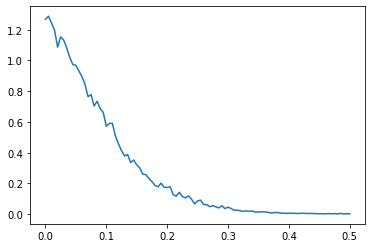

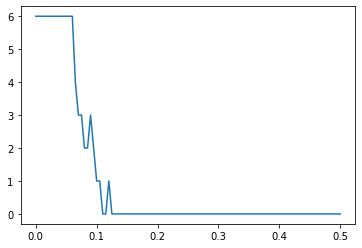

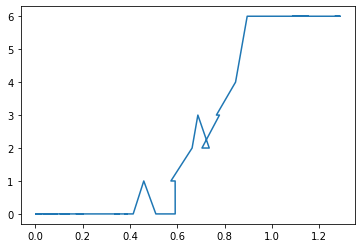

In [291]:
plt.plot(regs3, [eps.detach() for eps in eps_res])
plt.show()
plt.plot(regs3, loss_res)
plt.show()

plt.plot([eps.detach() for eps in eps_res], loss_res)

In [287]:
eps_res
#loss_res

[tensor(1.3064, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0020, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0008, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0013, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0007, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0005, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0012, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0007, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0008, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0011, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0011, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0010, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0015, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0007, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0010, dtype=torch.float64, grad_fn=<NormBackward1>),
 tensor(0.0013, dtype=torch.float64, grad_fn=<NormBackw

In [223]:
print(p_torch,"\n")
print(q,"\n")

d = torch_dist_maxpair(p_torch, torch.unsqueeze(q,0), torch_all_ranks, threshold=threshold)
print(d)
print(torch.norm(p_torch - torch.unsqueeze(q,0),1), "\n")

print(torch_maxpair(p_torch, torch_all_ranks, n=4, threshold=threshold))
print(torch_maxpair(torch.unsqueeze(q,0), torch_all_ranks, n=4, threshold=threshold))

tensor([[0.2075, 0.0855, 0.1132, 0.0214, 0.0380, 0.0175, 0.1563, 0.0644, 0.0586,
         0.0072, 0.0209, 0.0062, 0.0684, 0.0129, 0.0470, 0.0058, 0.0061, 0.0039,
         0.0209, 0.0096, 0.0152, 0.0045, 0.0055, 0.0036]], dtype=torch.float64) 

tensor([0.1969, 0.0831, 0.1130, 0.0213, 0.0390, 0.0176, 0.1443, 0.0646, 0.0680,
        0.0069, 0.0197, 0.0061, 0.0573, 0.0132, 0.0464, 0.0056, 0.0064, 0.0085,
        0.0227, 0.0097, 0.0168, 0.0096, 0.0157, 0.0078],
       grad_fn=<DivBackward0>) 

tensor(0.)
tensor(0.0774, dtype=torch.float64, grad_fn=<NormBackward1>) 

tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])
tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])


In [147]:
threshold

0.0

In [45]:
torch_smooth_maxpair(p_torch, p_torch, torch_all_ranks, 0.1)

tensor(0.)

In [38]:
a_ = torch.sum(R,axis=0)
print(a_)
b_ = torch.argsort(a_)
b_

tensor([1., 1., 3., 3.])


tensor([0, 1, 2, 3])

In [39]:
s1 = torch.tensor([0,1,2,3])
s2 = torch.tensor([3,2,1,0])
kendall_tau(s1, s2)

tensor(6.)